# Papcorns Data Scientist Task

## Mert OLCAMAN

### mertolcaman@gmail.com

## Imports

Let's do the imports:

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')  # Example with the 'whitegrid' style from Seaborn
sns.set_palette('deep')

## Connecting to the Database

Let's establish a connection to the SQLite database:

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('papcorns.sqlite')

## Exploring the Data Structure

Let's look at the structure of our tables:

In [3]:
# Load users table
users_df = pd.read_sql_query("SELECT * FROM users LIMIT 5;", conn)
print("Users table preview:")
display(users_df)

# Load events table
events_df = pd.read_sql_query("SELECT * FROM user_events LIMIT 5;", conn)
print("\nUser events table preview:")
display(events_df)

Users table preview:


id           created_at attribution_source country          name
0   1  2024-05-07T00:00:00          instagram      US     Eve Brown
1   2  2024-10-12T00:00:00          instagram      NL   Frank Moore
2   3  2024-10-15T00:00:00             tiktok      TR  Ivy Anderson
3   4  2024-08-28T00:00:00             tiktok      TR   Alice Brown
4   5  2024-04-03T00:00:00            organic      NL     Bob Moore


User events table preview:


id           created_at  user_id       event_name amount_usd
0   1  2024-05-07T00:00:00        1      app_install       None
1   2  2024-05-12T00:00:00        1    trial_started       None
2   3  2024-05-24T00:00:00        1  trial_cancelled       None
3   4  2024-10-12T00:00:00        2      app_install       None
4   5  2024-10-13T00:00:00        2    trial_started       None

# Creating a Query Function

In [4]:
def QF(query_text,connection):
    return pd.read_sql_query(query_text, connection)

creating a function makes the calling querries easier to write

In [5]:
dfUsers=QF("""SELECT* 
FROM users;
""",conn)
len(dfUsers)

1002

In [6]:
dfUserEvents=QF("""SELECT* 
FROM user_events;
""",conn)
len(dfUserEvents)

3486

Dataframe should be checked if there is a value missing to make the analysis more precise.

In [7]:
dfUserEvents[dfUserEvents.isnull()==True].count()

id            0
created_at    0
user_id       0
event_name    0
amount_usd    0
dtype: int64

In [8]:
QF("""SELECT
(SELECT count(*) 
FROM user_events) AS all_count_user_events,

(SELECT count(*)
FROM user_events 
WHERE id IS NULL
OR created_at IS NULL
OR user_id    IS NULL
OR event_name IS NULL
OR amount_usd IS NULL) AS null_count_user_events;
""", conn)

all_count_user_events  null_count_user_events
0                   3486                    2255

Even though it seems like there is no null value in user events table in pandas dataframe, it can be seen that there are null values in SQL query.

#### To find the columns which have null values

In [9]:
QF("""
SELECT
    COUNT(CASE WHEN id IS NULL THEN 1 END) AS id_null,
    COUNT(CASE WHEN created_at IS NULL THEN 1 END) AS created_at_null,
    COUNT(CASE WHEN user_id IS NULL THEN 1 END) AS user_id_null,
    COUNT(CASE WHEN event_name IS NULL THEN 1 END) AS event_name_null,
    COUNT(CASE WHEN amount_usd IS NULL THEN 1 END) AS amount_usd_null
FROM user_events;
""", conn)

id_null  created_at_null  user_id_null  event_name_null  amount_usd_null
0        0                0             0                0             2255

As it can be seen that all null values are in amount_usd column.
Using CASE structure make the scanning the whole table only once. Otherwise the whole table is scanned each time seperately.

The null values in the amount_usd_null column are expected that they are because of not related to paid events like subscription_started or subscription_renewed.

In [10]:
dfNull=QF("""
SELECT *
FROM user_events
""",conn)

In [11]:
for event in dfNull.event_name.unique():
    print(event,": ",len(dfNull[(dfNull["event_name"] == event) & (dfNull["amount_usd"].isnull())])
)

app_install :  1002
trial_started :  682
trial_cancelled :  201
subscription_started :  0
subscription_renewed :  0
subscription_cancelled :  370


As it can be seen above, they are as expected. Paid events don't contain any null values.

In [12]:
#to check the count of null values in each column
dfUsers[dfUsers.isnull()==True].count()

id                    0
created_at            0
attribution_source    0
country               0
name                  0
dtype: int64

In [13]:
QF("""SELECT
(SELECT count(*) 
FROM users) AS all_count_user_events,

(SELECT count(*)
FROM users 
WHERE id IS NULL
OR created_at         IS NULL
OR attribution_source IS NULL
OR country            IS NULL
OR name               IS NULL) AS null_count_user_events;
""", conn)

all_count_user_events  null_count_user_events
0                   1002                       0

Unlike user events table, there is no null value in user table.

# Question 1: Calculate the total revenue generated from subscriptions for each country

In [14]:
# Query to calculate the total revenue from subscriptions grouped by country.
dfQ1=QF("""
SELECT country, sum(amount_usd) as total_revenue_usd
FROM user_events as e
JOIN users as u ON u.id=e.user_id
WHERE amount_usd is not null
GROUP BY country;
""",conn)
dfQ1

country  total_revenue_usd
0      NL            3335.29
1      TR            2275.44
2      US            4035.96

# Question 2: Calculate the total number of trials given to users who came from Instagram

In [15]:
# Query to count the number of trials started by users who came from Instagram.
dfQ2=QF("""
SELECT u.attribution_source,COUNT(*) AS total_number_of_trials
FROM Users u
JOIN User_Events ue ON u.id = ue.user_id
WHERE u.attribution_source = 'instagram'
  AND ue.event_name = 'trial_started';
""",conn)
dfQ2

attribution_source  total_number_of_trials
0          instagram                     210

# Question3: Create a new column named 'acquisition_channel' by categorizing users based on their 'attribution_source':
                  * Paid': users from instagram or tiktok
                  *'Organic': users from organic sources

In [16]:
# Query to add a new column 'acquisition_channel' to classify users as 'Paid' or 'Organic'
# based on their attribution source. This helps in segmenting the users for marketing analysis.
dfQ3=QF("""
SELECT ue.user_id,
u.created_at as user_created_at,
u.name as user_name,
u.country,
ue.id as event_id,
ue.created_at as event_created_at,
ue.event_name,
u.attribution_source,
ue.amount_usd,
CASE 
           WHEN u.attribution_source IN ('instagram', 'tiktok') THEN 'Paid'
           ELSE 'Organic'
       END AS acquisition_channel
FROM user_events as ue
JOIN users as u ON u.id=ue.user_id;
""",conn)
dfQ3

user_id      user_created_at      user_name country  event_id  \
0           1  2024-05-07T00:00:00      Eve Brown      US         1   
1           1  2024-05-07T00:00:00      Eve Brown      US         2   
2           1  2024-05-07T00:00:00      Eve Brown      US         3   
3           2  2024-10-12T00:00:00    Frank Moore      NL         4   
4           2  2024-10-12T00:00:00    Frank Moore      NL         5   
...       ...                  ...            ...     ...       ...   
3481     1000  2025-02-13T00:00:00  Jack Anderson      NL      3482   
3482     1001  2025-02-16T00:00:00    Bruce Wayne      US      3483   
3483     1001  2025-02-16T00:00:00    Bruce Wayne      US      3484   
3484     1001  2025-02-16T00:00:00    Bruce Wayne      US      3485   
3485     1002  2025-02-16T00:00:00     Clark Kent      TR      3486   

         event_created_at            event_name attribution_source  \
0     2024-05-07T00:00:00           app_install          instagram   
1     2024-05-12T00:00:00         trial_started          instagram   
2     2024-05-24T00:00:00       trial_cancelled          instagram   
3     2024-10-12T00:00:00           app_install          instagram   
4     2024-10-13T00:00:00         trial_started          instagram   
...                   ...                   ...                ...   
3481  2025-02-25T00:00:00       trial_cancelled            organic   
3482  2025-02-25T00:00:00           app_install          instagram   
3483  2025-02-25T00:00:00         trial_started          instagram   
3484  2025-02-25T00:00:00  subscription_started          instagram   
3485  2025-02-25T00:00:00           app_install            organic   

      amount_usd acquisition_channel  
0            NaN                Paid  
1            NaN                Paid  
2            NaN                Paid  
3            NaN                Paid  
4            NaN                Paid  
...          ...                 ...  
3481         NaN             Organic  
3482         NaN                Paid  
3483         NaN                Paid  
3484        9.99                Paid  
3485         NaN             Organic  

[3486 rows x 10 columns]

# Question 4: Analyze the trial-to-subscription conversion rate

### Part-I: Calculate the overall conversion rate: (Subscription/trial)

From the query below, it can be seen that, if a user started the subscription, it appears under trial starting,
so dividing the count of subscription started by trial started will give the conversion rate

In [17]:
# Initial data retrieval for conversion analysis. This query fetches trials and subscriptions
# to prepare for calculating the conversion rate.
QF("""
SELECT ue.user_id,
u.created_at as user_created_at,
u.name as user_name,
u.country,
ue.id as event_id,
ue.created_at as event_created_at,
ue.event_name,
u.attribution_source,
ue.amount_usd
FROM user_events as ue
JOIN users as u ON u.id=ue.user_id
WHERE event_name="trial_started" or event_name="subscription_started" 
ORDER BY user_created_at and user_id;
""",conn)

user_id      user_created_at      user_name country  event_id  \
0           1  2024-05-07T00:00:00      Eve Brown      US         2   
1           2  2024-10-12T00:00:00    Frank Moore      NL         5   
2           2  2024-10-12T00:00:00    Frank Moore      NL         6   
3           3  2024-10-15T00:00:00   Ivy Anderson      TR        12   
4           3  2024-10-15T00:00:00   Ivy Anderson      TR        13   
...       ...                  ...            ...     ...       ...   
1158      999  2024-12-24T00:00:00  Charlie Davis      NL      3475   
1159      999  2024-12-24T00:00:00  Charlie Davis      NL      3476   
1160     1000  2025-02-13T00:00:00  Jack Anderson      NL      3481   
1161     1001  2025-02-16T00:00:00    Bruce Wayne      US      3484   
1162     1001  2025-02-16T00:00:00    Bruce Wayne      US      3485   

         event_created_at            event_name attribution_source  amount_usd  
0     2024-05-12T00:00:00         trial_started          instagram         NaN  
1     2024-10-13T00:00:00         trial_started          instagram         NaN  
2     2024-10-20T00:00:00  subscription_started          instagram        8.99  
3     2024-10-19T00:00:00         trial_started             tiktok         NaN  
4     2024-10-21T00:00:00  subscription_started             tiktok        4.99  
...                   ...                   ...                ...         ...  
1158  2024-12-29T00:00:00         trial_started            organic         NaN  
1159  2025-01-03T00:00:00  subscription_started            organic        8.99  
1160  2025-02-15T00:00:00         trial_started            organic         NaN  
1161  2025-02-25T00:00:00         trial_started          instagram         NaN  
1162  2025-02-25T00:00:00  subscription_started          instagram        9.99  

[1163 rows x 9 columns]

### Calculating the rate:

In [18]:
dfQ4=QF("""
SELECT
round(cast(SUM(CASE WHEN event_name = 'subscription_started' THEN 1 ELSE 0 END) as float)
        / 
        cast(SUM(CASE WHEN event_name = 'trial_started' THEN 1 ELSE 0 END) as float),4)
        as Conversion_Rate
FROM user_events as ue
JOIN users as u ON u.id=ue.user_id
""",conn)
dfQ4

Conversion_Rate
0           0.7053

### Part-II: Break down the conversion rate by attribution_source

In [19]:
# Query to break down the conversion rate by attribution source. This provides insight into
# which channels are most effective at converting trials into subscriptions.
dfQ4_2=QF("""
SELECT
attribution_source,
        round(cast(SUM(CASE WHEN event_name = 'subscription_started' THEN 1 ELSE 0 END) as float)
        / 
        cast(SUM(CASE WHEN event_name = 'trial_started' THEN 1 ELSE 0 END) as float),4)
        as Conversion_Rate
FROM user_events as ue
JOIN users as u ON u.id=ue.user_id
GROUP BY attribution_source;
""",conn)
dfQ4_2

attribution_source  Conversion_Rate
0          instagram           0.7095
1            organic           0.7161
2             tiktok           0.6907

# Question 5: Calculate the median subscription duration (in months) for each country

### Calculation of Subscription Duration and Median Subscription Duration

In this analysis, we calculate subscription durations for users, considering different user statuses (active and inactive) and countries. We also calculate the median subscription duration for each group: active users, inactive users, and all users combined.

#### Handling Date Variations Across Countries

**Max Event Date by Country:** The maximum event date varies for each country. To ensure consistency in calculating the subscription end date, we find the most recent event date for each country. This date is used as a reference for users who have not cancelled their subscription, so that the subscription duration is correctly calculated.

#### Subscription Duration Calculation

**Julian Day Conversion:** The subscription start and end dates are converted to Julian days using the `julianday()` function. This conversion allows us to perform accurate date calculations, regardless of month length or leap years. Julian days represent the number of days since the Julian calendar started and offer a precise way to calculate durations.

**Monthly Conversion Calculation:**

To convert the subscription period from days to months, we use the average number of days per month:

- **Calculation Basis:** The average number of days per month is approximately \(30.42\). This is derived from dividing the total number of days in a year by 12 months:
    $$
    \text{Average Days per Month} = \frac{365 \text{ days}}{12 \text{ months}} = 30.42 \text{ days/month}
    $$

- **Conversion Formula:** To convert a time span from Julian days to months, we use the following formula:
    $$
    \text{Months} = \frac{\text{Julian Day Value}}{30.42}
    $$

This formula provides an approximation of the subscription period in months, making it easier to analyze and compare subscription durations over a monthly timescale.








    
    
    
    
#### Finding the Median Subscription Duration

**Ordering and Median Calculation:** For each country, we order the subscription durations for users based on their status (active or inactive). The median is determined by selecting the middle value from the sorted list. If the number of users is odd, the median is the middle value; if the number is even, the median is the average of the two middle values. This method ensures that the median is not influenced by extreme values, providing a robust measure of central tendency.

Specifically, the **active median** is calculated for users who are still subscribed, the **inactive median** is calculated for users who have cancelled their subscription, and the **combined median** is calculated for all users, regardless of their status.

#### Key Points in the Query:

- **Event-Based Calculation:** Subscription start dates are taken from the latest `subscription_started` event. Subscription end dates are determined either by the `subscription_cancelled` event (if the user cancelled their subscription) or the most recent event date for ongoing subscriptions.
  
- **Ranking and Row Numbering:** The `ROW_NUMBER()` function assigns a rank to each user's subscription duration within their country and status group (active or inactive), which is necessary for finding the median. The `COUNT()` function is used to determine the total number of users in each group, which helps in calculating the median based on whether the total count is odd or even.
  
- **Rounded Output:** The results are rounded to two decimal places to provide a cleaner and more readable output for the subscription durations in months. This makes the data more suitable for reports and analysis.

This approach gives us a clear understanding of how long users typically remain subscribed, both for those who have cancelled and for those who are still active, with the flexibility to handle different countries and time periods.


### Using only SQL:

In [20]:
dfQ5=QF("""
WITH MaxDatePerCountry AS (
    -- calculates the latest event date for each country
    -- It finds the maximum event creation date for users in each country
    -- based on the 'subscription_started' or 'subscription_cancelled' events.
    SELECT u.country, MAX(ue.created_at) AS max_event_date
    FROM Users u
    JOIN User_Events ue ON u.id = ue.user_id
    WHERE ue.event_name IN ('subscription_started', 'subscription_cancelled')
    GROUP BY u.country
),
UserSubscriptionData AS (
    -- collects subscription data for each user
    -- It calculates the subscription period (in days) and determines whether the user is active or inactive.
    -- It uses the most recent 'subscription_started' and 'subscription_cancelled' events for each user.
    SELECT u.id, u.name, u.country,
           -- Get the latest subscription start date
           MAX(CASE WHEN ue.event_name = 'subscription_started' THEN ue.created_at END) AS subscription_start,
           -- Get the cancellation date or use the latest event date from the MaxDatePerCountry CTE if the user hasn't canceled their subscription
           COALESCE(MAX(CASE WHEN ue.event_name = 'subscription_cancelled' THEN ue.created_at END),
                    (SELECT max_event_date FROM MaxDatePerCountry WHERE country = u.country)) AS subscription_end,
           -- Determine if the user is active or inactive
           CASE 
               WHEN MAX(CASE WHEN ue.event_name = 'subscription_cancelled' THEN ue.created_at END) IS NOT NULL THEN 'Inactive'
               ELSE 'Active'
           END AS user_status,
           -- Calculate the subscription period in days
           julianday(
               COALESCE(MAX(CASE WHEN ue.event_name = 'subscription_cancelled' THEN ue.created_at END),
                        (SELECT max_event_date FROM MaxDatePerCountry WHERE country = u.country))
           ) - julianday(
               MAX(CASE WHEN ue.event_name = 'subscription_started' THEN ue.created_at END)
           ) AS subscription_period_days
    FROM Users u
    JOIN User_Events ue ON u.id = ue.user_id
    WHERE ue.event_name IN ('subscription_started', 'subscription_cancelled')
    GROUP BY u.id, u.country
),
RankedSubscriptionData AS (
    -- calculates the row number for each user's subscription period based on their country and status (active or inactive).
    -- It also calculates the total number of users in each country and status (active or inactive).
    SELECT u.country, u.user_status, u.subscription_period_days,
           -- Assign a row number to each user within their country and status group, ordered by subscription period.
           ROW_NUMBER() OVER (PARTITION BY u.country, u.user_status ORDER BY u.subscription_period_days) AS row_num,
           -- Count the total number of users in each group (country and status).
           COUNT(*) OVER (PARTITION BY u.country, u.user_status) AS total_rows
    FROM UserSubscriptionData u
)
SELECT r.country,
       -- Active median in months, rounded to 2 decimal places
       ROUND(CASE
           -- If the number of active users is odd, return the middle value
           WHEN active_rows.total_rows % 2 = 1 THEN
               (SELECT subscription_period_days / 30.42
                FROM RankedSubscriptionData
                WHERE country = r.country AND user_status = 'Active'
                AND row_num = (active_rows.total_rows + 1) / 2)
           -- If the number of active users is even, return the average of the two middle values
           ELSE
               (SELECT AVG(subscription_period_days) / 30.42
                FROM RankedSubscriptionData
                WHERE country = r.country AND user_status = 'Active'
                AND row_num IN (active_rows.total_rows / 2, (active_rows.total_rows / 2) + 1))
       END, 2) AS active_median,
       -- Inactive median in months, rounded to 2 decimal places
       ROUND(CASE
           -- If the number of inactive users is odd, return the middle value
           WHEN inactive_rows.total_rows % 2 = 1 THEN
               (SELECT subscription_period_days / 30.42
                FROM RankedSubscriptionData
                WHERE country = r.country AND user_status = 'Inactive'
                AND row_num = (inactive_rows.total_rows + 1) / 2)
           -- If the number of inactive users is even, return the average of the two middle values
           ELSE
               (SELECT AVG(subscription_period_days) / 30.42
                FROM RankedSubscriptionData
                WHERE country = r.country AND user_status = 'Inactive'
                AND row_num IN (inactive_rows.total_rows / 2, (inactive_rows.total_rows / 2) + 1))
       END, 2) AS inactive_median,
       -- Median for both active and inactive users combined in months, rounded to 2 decimal places
       ROUND(CASE
           -- If the total number of users is odd, return the middle value
           WHEN combined_rows.total_rows % 2 = 1 THEN
               (SELECT subscription_period_days / 30.42
                FROM RankedSubscriptionData
                WHERE country = r.country
                AND row_num = (combined_rows.total_rows + 1) / 2)
           -- If the total number of users is even, return the average of the two middle values
           ELSE
               (SELECT AVG(subscription_period_days) / 30.42
                FROM RankedSubscriptionData
                WHERE country = r.country
                AND row_num IN (combined_rows.total_rows / 2, (combined_rows.total_rows / 2) + 1))
       END, 2) AS both_active_inactive_median
FROM RankedSubscriptionData r
-- Join to get the count of active users in each country
JOIN (
    SELECT country, COUNT(*) AS total_rows
    FROM RankedSubscriptionData
    WHERE user_status = 'Active'
    GROUP BY country
) active_rows ON r.country = active_rows.country
-- Join to get the count of inactive users in each country
JOIN (
    SELECT country, COUNT(*) AS total_rows
    FROM RankedSubscriptionData
    WHERE user_status = 'Inactive'
    GROUP BY country
) inactive_rows ON r.country = inactive_rows.country
-- Join to get the total number of users in each country (active + inactive)
JOIN (
    SELECT country, COUNT(*) AS total_rows
    FROM RankedSubscriptionData
    GROUP BY country
) combined_rows ON r.country = combined_rows.country
GROUP BY r.country;

""",conn)

dfQ5

country  active_median  inactive_median  both_active_inactive_median
0      NL          10.03             2.28                         2.73
1      TR          10.82             2.50                         3.06
2      US          11.05             2.24                         2.56

# Question 6: Calculate the Average Lifetime Value (LTV) by country

### Mathematical Formulation and Explanation of the LTV Calculation Process

**1. Definition of Key Metrics:**
   - **New Customers \((N)\):** Number of unique customers who either installed the app, started a trial, or began a subscription in a given month.
   - **Churned Customers \((C)\):** Number of unique customers who either cancelled their trial or subscription in the same month.
   - **Revenue \((R)\):** Total revenue generated from all users within the month.

**2. Calculation of Customer Base Each Month:**
   - **Customers at the Beginning of the Month \((CB)\):** This is calculated using a cumulative sum of net new customers (new minus churned) from the beginning of the data collection, adjusted month by month.

**3. Average Customer Base Calculation:**
   - For LTV, it‚Äôs important to consider the average customer base over the period to account for both the start and end of the month:
   
   
   
   $$
   \text{Average Customers} = \frac{CB + (CB + N - C)}{2}
   $$
   
   
   
   This formula takes the customer count at the beginning \((CB)\) and the end \((CB + N - C)\) of the month, averaging them to find the typical customer base during that month.

**4. Churn Rate Calculation:**
   - The churn rate is a critical metric reflecting customer retention:
   
   
   $$
   \text{Churn Rate} = 
   \begin{cases} 
   \frac{C}{N} & \text{if } CB = 0 \\
   \frac{C}{CB} & \text{otherwise}
   \end{cases}
   $$
   
   
   This conditional approach accounts for whether the month started with any customers (to avoid division by zero).

**5. Average Revenue Per User (ARPU):**
   - ARPU is calculated as:
   
   
   $$
   \text{ARPU} = \frac{R}{\text{Average Customers}}
   $$
   

**6. Lifetime Value (LTV) Calculation:**
   - Finally, the LTV is derived by dividing the total revenue by the product of the average customers and the churn rate. This represents the revenue each customer brings to the company over their 'lifetime' given the current churn rates:
   
   
$$
\text{LTV} = \frac{\text{ARPU}}{\text{Churn Rate}}
$$






In [21]:
dfQ6=QF("""
WITH user_activity AS (
-- the count of new users and churned users
    SELECT 
        strftime('%Y-%m', ue.created_at) AS month,
        country,
        COUNT(DISTINCT CASE 
            WHEN event_name IN ('app_installed', 'trial_started', 'subscription_started') THEN u.id 
        END) AS new_customers,
        COUNT(DISTINCT CASE 
            WHEN event_name IN ('trial_cancelled', 'subscription_cancelled') THEN u.id 
        END) AS cancelled_customers
    FROM user_events AS ue
    JOIN users AS u ON ue.user_id = u.id
    GROUP BY month, country
),
customer_growth AS (
-- the customer number at the beginning of each period
    SELECT 
        month,
        country,
        new_customers,
        cancelled_customers,
        SUM(new_customers - cancelled_customers) 
            OVER (PARTITION BY country ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) 
        AS total_customer_beginning
    FROM user_activity
),
revenue_data AS (
-- total revenue per period
    SELECT 
        strftime('%Y-%m', ue.created_at) AS month,
        country,
        SUM(ue.amount_usd) AS revenue
    FROM user_events AS ue
    JOIN users AS u ON ue.user_id = u.id
    GROUP BY month, country
),
ltv_data AS (
    SELECT 
        cg.month,
        cg.country,
        COALESCE(cg.total_customer_beginning, 0) AS total_customer_beginning,
        cg.new_customers,
        cg.cancelled_customers,
        (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers) AS total_customer_end,
        -- average customer number => [(number at the beginning)+ (number at the end)] /2
        ROUND(
            (COALESCE(cg.total_customer_beginning, 0) + 
             (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers)) / 2.0, 
            2
        ) AS average_customer,
        -- churn rate calculation
        CASE 
        -- if the customer number at the beginning of the period is 0, in other words the first month with 0 customer at the beginning		
            WHEN cg.total_customer_beginning IS NULL OR cg.total_customer_beginning = 0 
            THEN ROUND(
                CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.new_customers, 0), 9
            ) 
            ELSE ROUND(
                CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.total_customer_beginning, 0), 9
            )
        END AS churn_rate,
        COALESCE(rd.revenue, 0) AS revenue,
        -- Average Revenue Per User (ARPU) Calculation
        ROUND(COALESCE(rd.revenue, 0) / NULLIF(
            (COALESCE(cg.total_customer_beginning, 0) + 
             (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers)) / 2.0, 0), 2
        ) AS ARPU,
        -- Lifetime Value (LTV) Calculation
        COALESCE(
            ROUND(
                COALESCE(rd.revenue, 0) / NULLIF(
                    ((COALESCE(cg.total_customer_beginning, 0) + 
                     (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers)) / 2.0) 
                    * NULLIF(
                        CASE 
                            WHEN cg.total_customer_beginning IS NULL OR cg.total_customer_beginning = 0 
                            THEN CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.new_customers, 0)
                            ELSE CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.total_customer_beginning, 0)
                        END, 0
                    ), 0
                ), 2
            ), 0
        ) AS LTV

    FROM customer_growth cg
    LEFT JOIN revenue_data rd ON cg.month = rd.month AND cg.country = rd.country
)
SELECT 
    country,
    ROUND(AVG(LTV), 2) AS average_LTV
FROM ltv_data
GROUP BY country
ORDER BY average_LTV DESC;


""",conn)
dfQ6

country  average_LTV
0      NL        21.35
1      US        19.72
2      TR        12.07

# BONUS TASKS

# Question 7: Predict the churn probability for user #1002 (Clark Kent)

# **Model Selection & Feature Engineering Process**

To predict **churn probability**, multiple models were trained and evaluated to assess their effectiveness.

## **Model Selection**
- **Logistic Regression** ‚Äì Baseline model, interpretable and effective for binary classification.
- **Random Forest & Gradient Boosting** ‚Äì Handles non-linearity and provides feature importance insights.
- **XGBoost** ‚Äì Optimized gradient boosting model, effective for structured data.
- **Support Vector Machine (SVM)** ‚Äì Maximizes class separation for better predictions.
- **K-Nearest Neighbors (KNN)** ‚Äì Compares users with similar behavioral patterns.

---

## **Feature Engineering**
To enhance model performance, various user activity, financial, and comparative metrics were engineered.

### **Temporal Features**
- **`days_difference`** ‚Äì Time between events, indicating user engagement frequency.
- **`cumulative_user_activity`** ‚Äì Tracks the number of events per user, a good indicator of engagement.

### **Financial Metrics**
- **`cumulative_user_spending_usd`** ‚Äì Measures total user spending, indicating financial commitment.
- **`mean_user_spending_usd`** ‚Äì Differentiates users based on spending behavior.
- **`LTV_previous`** ‚Äì Captures previous lifetime value estimations.

### **Comparative Metrics**
- **`country_mean_spending_usd`** ‚Äì Allows comparison of a user‚Äôs spending against the country average.
- **`cumulative_country_spending_usd`** ‚Äì Represents the total spending within the user‚Äôs country.

### **Churn-Related Features**
- **`source_cumulative_churn_rate`** ‚Äì Historical churn rate associated with each acquisition source.
- **`churn_rate_previous`** ‚Äì Historical churn trends, useful as a predictive signal.

### **Customer Dynamics**
- **`total_customer_beginning_previous`** & **`total_customer_end_previous`** ‚Äì Indicates the size of the user base at the start and end of previous periods.
- **`new_customers_previous`** & **`cancelled_customers_previous`** ‚Äì Reflects user base growth and loss trends.

### **One-Hot Encoding**
- Categorical variables **(`country`, `source`, `event_name`)** were transformed into **binary features** to allow machine learning models to process them effectively.

---

# **Methodology & Assumptions**

## **1. Handling Class Imbalance**
- The dataset was **imbalanced**, with **churned users significantly outnumbering non-churned users**.
- **Hybrid balancing techniques were used:**
  - **Undersampling** (removing some churned users).
  - **Oversampling using SMOTE** (synthetic minority oversampling for non-churned users).

## **2. Model Evaluation Metrics**
To assess model effectiveness, multiple metrics were used:
- **Accuracy** ‚Äì Measures correct classifications.
- **ROC-AUC Score** ‚Äì Evaluates how well the model distinguishes between churned and non-churned users.
- **Precision, Recall, F1-Score** ‚Äì Balances the trade-off between false positives and false negatives.

## **3. Ensemble Approach for Churn Prediction**
Since different models provide varying performance, **weighted averaging** was applied to combine predictions.

### **Weighted Churn Probability Formula**
$$
P_{\text{ensemble}} = \frac{\sum (ROC_i \times P_i)}{\sum ROC_i}
$$

where:
- \( P_i \) is the churn probability predicted by model \( i \).
- \( ROC_i \) is the model‚Äôs **ROC-AUC score**, which acts as a weight.

The **final predicted churn probability** for **User #1002 (Clark Kent)** was determined using this **ensemble method**, ensuring that models with higher accuracy influenced the prediction more significantly.


In [22]:
df=QF("""
SELECT 
    u.created_at as user_created_at,
    u.id as user_id,
    u.country,
    ue.created_at as event_created_at,
    u.attribution_source as source,
    ue.event_name,
    ue.amount_usd
FROM users as u
LEFT JOIN user_events as ue on u.id=ue.user_id
""",conn)

In [23]:
df

user_created_at  user_id country     event_created_at     source  \
0     2024-05-07T00:00:00        1      US  2024-05-07T00:00:00  instagram   
1     2024-05-07T00:00:00        1      US  2024-05-12T00:00:00  instagram   
2     2024-05-07T00:00:00        1      US  2024-05-24T00:00:00  instagram   
3     2024-10-12T00:00:00        2      NL  2024-10-12T00:00:00  instagram   
4     2024-10-12T00:00:00        2      NL  2024-10-13T00:00:00  instagram   
...                   ...      ...     ...                  ...        ...   
3481  2025-02-13T00:00:00     1000      NL  2025-02-25T00:00:00    organic   
3482  2025-02-16T00:00:00     1001      US  2025-02-25T00:00:00  instagram   
3483  2025-02-16T00:00:00     1001      US  2025-02-25T00:00:00  instagram   
3484  2025-02-16T00:00:00     1001      US  2025-02-25T00:00:00  instagram   
3485  2025-02-16T00:00:00     1002      TR  2025-02-25T00:00:00    organic   

                event_name  amount_usd  
0              app_install         NaN  
1            trial_started         NaN  
2          trial_cancelled         NaN  
3              app_install         NaN  
4            trial_started         NaN  
...                    ...         ...  
3481       trial_cancelled         NaN  
3482           app_install         NaN  
3483  subscription_started        9.99  
3484         trial_started         NaN  
3485           app_install         NaN  

[3486 rows x 7 columns]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_created_at   3486 non-null   object 
 1   user_id           3486 non-null   int64  
 2   country           3486 non-null   object 
 3   event_created_at  3486 non-null   object 
 4   source            3486 non-null   object 
 5   event_name        3486 non-null   object 
 6   amount_usd        1231 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 190.8+ KB


In [25]:
# Convert 'user_created_at' and 'event_created_at' to datetime type
df['user_created_at'] = pd.to_datetime(df['user_created_at'])
df['event_created_at'] = pd.to_datetime(df['event_created_at'])

In [26]:
df

user_created_at  user_id country event_created_at     source  \
0         2024-05-07        1      US       2024-05-07  instagram   
1         2024-05-07        1      US       2024-05-12  instagram   
2         2024-05-07        1      US       2024-05-24  instagram   
3         2024-10-12        2      NL       2024-10-12  instagram   
4         2024-10-12        2      NL       2024-10-13  instagram   
...              ...      ...     ...              ...        ...   
3481      2025-02-13     1000      NL       2025-02-25    organic   
3482      2025-02-16     1001      US       2025-02-25  instagram   
3483      2025-02-16     1001      US       2025-02-25  instagram   
3484      2025-02-16     1001      US       2025-02-25  instagram   
3485      2025-02-16     1002      TR       2025-02-25    organic   

                event_name  amount_usd  
0              app_install         NaN  
1            trial_started         NaN  
2          trial_cancelled         NaN  
3              app_install         NaN  
4            trial_started         NaN  
...                    ...         ...  
3481       trial_cancelled         NaN  
3482           app_install         NaN  
3483  subscription_started        9.99  
3484         trial_started         NaN  
3485           app_install         NaN  

[3486 rows x 7 columns]

In [27]:
print("The null count per event:")
print("--------------------------------------")
for event in df.event_name.unique():
    print(event, ": ", len(df[(df.event_name==event)&(df.amount_usd.isna())]))

The null count per event:
--------------------------------------
app_install :  1002
trial_started :  682
trial_cancelled :  201
subscription_started :  0
subscription_renewed :  0
subscription_cancelled :  370


Filling NaN values in amount_usd with 0 

In [28]:
#filling the NaN values by 0 in amount_usd, since the money wasn't spent during that times.
df.amount_usd=df.amount_usd.fillna(0)

In [29]:
df

user_created_at  user_id country event_created_at     source  \
0         2024-05-07        1      US       2024-05-07  instagram   
1         2024-05-07        1      US       2024-05-12  instagram   
2         2024-05-07        1      US       2024-05-24  instagram   
3         2024-10-12        2      NL       2024-10-12  instagram   
4         2024-10-12        2      NL       2024-10-13  instagram   
...              ...      ...     ...              ...        ...   
3481      2025-02-13     1000      NL       2025-02-25    organic   
3482      2025-02-16     1001      US       2025-02-25  instagram   
3483      2025-02-16     1001      US       2025-02-25  instagram   
3484      2025-02-16     1001      US       2025-02-25  instagram   
3485      2025-02-16     1002      TR       2025-02-25    organic   

                event_name  amount_usd  
0              app_install        0.00  
1            trial_started        0.00  
2          trial_cancelled        0.00  
3              app_install        0.00  
4            trial_started        0.00  
...                    ...         ...  
3481       trial_cancelled        0.00  
3482           app_install        0.00  
3483  subscription_started        9.99  
3484         trial_started        0.00  
3485           app_install        0.00  

[3486 rows x 7 columns]

It can be seen that there is no NaN values in the table after filling them with 0.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_created_at   3486 non-null   datetime64[ns]
 1   user_id           3486 non-null   int64         
 2   country           3486 non-null   object        
 3   event_created_at  3486 non-null   datetime64[ns]
 4   source            3486 non-null   object        
 5   event_name        3486 non-null   object        
 6   amount_usd        3486 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 190.8+ KB


In [31]:
#find churned users
churned_users={}
for (user,event) in zip(df.user_id,df.event_name):
    if event in ["trial_cancelled","subscription_cancelled"]: churned_users[user]=1
    else: churned_users[user]=0

In [32]:
df[df.user_id==2]

user_created_at  user_id country event_created_at     source  \
3      2024-10-12        2      NL       2024-10-12  instagram   
4      2024-10-12        2      NL       2024-10-13  instagram   
5      2024-10-12        2      NL       2024-10-20  instagram   
6      2024-10-12        2      NL       2024-11-19  instagram   
7      2024-10-12        2      NL       2024-12-19  instagram   
8      2024-10-12        2      NL       2025-01-18  instagram   
9      2024-10-12        2      NL       2025-02-12  instagram   

               event_name  amount_usd  
3             app_install        0.00  
4           trial_started        0.00  
5    subscription_started        8.99  
6    subscription_renewed        8.99  
7    subscription_renewed        8.99  
8    subscription_renewed        8.99  
9  subscription_cancelled        0.00

In [33]:
sum(df[(df["user_id"] == 2) & 
                                                (df["event_created_at"] <= "2025-02-12")].amount_usd)

35.96

In [34]:
#add a new column as churned
df["churned"]=df["user_id"].apply(lambda x: churned_users[x])

#getting the difference in terms of day between when the user was created and when the activies were done
df["days_difference"]=(df['event_created_at'] - df['user_created_at']).dt.days

#find the total user activity until the activity date
df["cumulative_user_activity"]=df.apply(lambda row: len(df[(df["user_id"] == row["user_id"]) & 
                                                (df["event_created_at"] <= row["event_created_at"])]), axis=1)

#find the cumulative user spending amount until the activity date
df["cumulative_user_spending_usd"]=df.apply(lambda row: sum(df[(df["user_id"] == row["user_id"]) & 
                                                (df["event_created_at"] <= row["event_created_at"])].amount_usd), axis=1)

#find the mean user spending amount until the activity date
df["mean_user_spending_usd"]=df.apply(lambda row: np.mean(df[(df["user_id"] == row["user_id"]) & 
                                                (df["event_created_at"] <= row["event_created_at"])].amount_usd), axis=1)

#find the country average spending until the activity date
df["country_mean_spending_usd"]=df.apply(lambda row: np.mean(df[(df["event_created_at"] <= row["event_created_at"])&
                                                (df["country"] == row["country"])].amount_usd), axis=1)

#find the cumulative country spending amount until the activity date
df["cumulative_country_spending_usd"]=df.apply(lambda row: sum(df[(df["event_created_at"] <= row["event_created_at"])&
                                                            (df["country"] == row["country"])].amount_usd), axis=1)


In [35]:
print("The number of records from each sources:")
print("----------------------------------------")
for i in df.source.unique():
    print(i, len(df[df.source==i]))

The number of records from each sources:
----------------------------------------
instagram 1081
tiktok 1182
organic 1223


Since the number of records from 3 sources are similar, we can use source-based approaches

In [36]:
def sourceChurnRate(df, source, date):
    churnedCount = len(df[(df["source"] == source) & (df["churned"] == 1) & (df["event_created_at"] <= date)])
    notChurnedCount = len(df[(df["source"] == source) & (df["churned"] == 0) & (df["event_created_at"] <= date)])
    
    if churnedCount + notChurnedCount == 0:
        return 0  # Avoid division by zero and handle cases with no prior data
    return churnedCount / (churnedCount + notChurnedCount)


In [37]:
#finds the cumulative churn rate until the event_created_at date
df["source_cumulative_churn_rate"]=df.apply(lambda row: sourceChurnRate(df, row["source"], row["event_created_at"]), axis=1)

In [38]:
df

user_created_at  user_id country event_created_at     source  \
0         2024-05-07        1      US       2024-05-07  instagram   
1         2024-05-07        1      US       2024-05-12  instagram   
2         2024-05-07        1      US       2024-05-24  instagram   
3         2024-10-12        2      NL       2024-10-12  instagram   
4         2024-10-12        2      NL       2024-10-13  instagram   
...              ...      ...     ...              ...        ...   
3481      2025-02-13     1000      NL       2025-02-25    organic   
3482      2025-02-16     1001      US       2025-02-25  instagram   
3483      2025-02-16     1001      US       2025-02-25  instagram   
3484      2025-02-16     1001      US       2025-02-25  instagram   
3485      2025-02-16     1002      TR       2025-02-25    organic   

                event_name  amount_usd  churned  days_difference  \
0              app_install        0.00        1                0   
1            trial_started        0.00        1                5   
2          trial_cancelled        0.00        1               17   
3              app_install        0.00        1                0   
4            trial_started        0.00        1                1   
...                    ...         ...      ...              ...   
3481       trial_cancelled        0.00        1               12   
3482           app_install        0.00        0                9   
3483  subscription_started        9.99        0                9   
3484         trial_started        0.00        0                9   
3485           app_install        0.00        0                9   

      cumulative_user_activity  cumulative_user_spending_usd  \
0                            1                          0.00   
1                            2                          0.00   
2                            3                          0.00   
3                            1                          0.00   
4                            2                          0.00   
...                        ...                           ...   
3481                         3                          0.00   
3482                         3                          9.99   
3483                         3                          9.99   
3484                         3                          9.99   
3485                         1                          0.00   

      mean_user_spending_usd  country_mean_spending_usd  \
0                       0.00                   3.000530   
1                       0.00                   2.966314   
2                       0.00                   2.940000   
3                       0.00                   3.057912   
4                       0.00                   3.053208   
...                      ...                        ...   
3481                    0.00                   3.072091   
3482                    3.33                   3.321048   
3483                    3.33                   3.321048   
3484                    3.33                   3.321048   
3485                    0.00                   1.714910   

      cumulative_country_spending_usd  source_cumulative_churn_rate  
0                              849.15                      0.793578  
1                              869.13                      0.792208  
2                              979.02                      0.794118  
3                             2094.67                      0.830104  
4                             2103.66                      0.829630  
...                               ...                           ...  
3481                          3173.47                      0.811694  
3482                          3706.29                      0.815249  
3483                          3706.29                      0.815249  
3484                          3706.29                      0.815249  
3485                          1991.01                      0.811694  

[3486 rows x 15 columns]

Using some part of the query in the question6 can be useful for feature engineering. We can use the previous period's data for each period in df

In [39]:
df2=QF("""
WITH user_activity AS (
-- the count of new users and churned users
    SELECT 
        strftime('%Y-%m', ue.created_at) AS month,
        country,
        COUNT(DISTINCT CASE 
            WHEN event_name IN ('app_installed', 'trial_started', 'subscription_started') THEN u.id 
        END) AS new_customers,
        COUNT(DISTINCT CASE 
            WHEN event_name IN ('trial_cancelled', 'subscription_cancelled') THEN u.id 
        END) AS cancelled_customers
    FROM user_events AS ue
    JOIN users AS u ON ue.user_id = u.id
    GROUP BY month, country
),
customer_growth AS (
-- the customer number at the beginning of each period
    SELECT 
        month,
        country,
        new_customers,
        cancelled_customers,
        SUM(new_customers - cancelled_customers) 
            OVER (PARTITION BY country ORDER BY month ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) 
        AS total_customer_beginning
    FROM user_activity
),
revenue_data AS (
-- total revenue per period
    SELECT 
        strftime('%Y-%m', ue.created_at) AS month,
        country,
        SUM(ue.amount_usd) AS revenue
    FROM user_events AS ue
    JOIN users AS u ON ue.user_id = u.id
    GROUP BY month, country
)
SELECT 
    cg.month,
    cg.country,
    COALESCE(cg.total_customer_beginning, 0) AS total_customer_beginning,
    cg.new_customers,
    cg.cancelled_customers,
    (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers) AS total_customer_end,
    -- average customer number => [(number at the beginning)+ (number at the end)] /2
    ROUND(
        (COALESCE(cg.total_customer_beginning, 0) + 
         (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers)) / 2.0, 
        2
    ) AS average_customer,

    -- churn rate calculation
    CASE 
    -- if the customer number at the beginning of the period is 0, in other words the first month with 0 customer at the beginning
        WHEN cg.total_customer_beginning IS NULL OR cg.total_customer_beginning = 0         
        THEN ROUND(
            CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.new_customers, 0), 9
        ) 
        ELSE ROUND(
            CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.total_customer_beginning, 0), 9
        )
    END AS churn_rate,

    COALESCE(rd.revenue, 0) AS revenue,

-- Average Revenue Per User (ARPU) Calculation
    ROUND(COALESCE(rd.revenue, 0) / NULLIF(
        (COALESCE(cg.total_customer_beginning, 0) + 
         (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers)) / 2.0, 0), 2
    ) AS ARPU,

-- Lifetime Value (LTV) Calculation
    COALESCE(
    ROUND(
        COALESCE(rd.revenue, 0) / NULLIF(
            ((COALESCE(cg.total_customer_beginning, 0) + 
             (COALESCE(cg.total_customer_beginning, 0) + cg.new_customers - cg.cancelled_customers)) / 2.0) 
            * NULLIF(
                CASE 
                    WHEN cg.total_customer_beginning IS NULL OR cg.total_customer_beginning = 0 
                    THEN CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.new_customers, 0)
                    ELSE CAST(cg.cancelled_customers AS FLOAT) / NULLIF(cg.total_customer_beginning, 0)
                END, 0
            ), 0
        ), 2
    ), 0
) AS LTV
FROM customer_growth cg
LEFT JOIN revenue_data rd ON cg.month = rd.month AND cg.country = rd.country
ORDER BY cg.country, cg.month;
""",conn)

In [40]:
df2

month country  total_customer_beginning  new_customers  \
0   2024-01      NL                         0             15   
1   2024-02      NL                        11             14   
2   2024-03      NL                        23             17   
3   2024-04      NL                        34             22   
4   2024-05      NL                        49             19   
5   2024-06      NL                        53             16   
6   2024-07      NL                        57             20   
7   2024-08      NL                        61             14   
8   2024-09      NL                        59             18   
9   2024-10      NL                        68             22   
10  2024-11      NL                        72             19   
11  2024-12      NL                        79             25   
12  2025-01      NL                        91             18   
13  2025-02      NL                        94             10   
14  2025-03      NL                        90              0   
15  2025-04      NL                        83              0   
16  2025-05      NL                        76              0   
17  2024-01      TR                         0              7   
18  2024-02      TR                         5             17   
19  2024-03      TR                        18             21   
20  2024-04      TR                        31             27   
21  2024-05      TR                        46             21   
22  2024-06      TR                        56             15   
23  2024-07      TR                        59             29   
24  2024-08      TR                        66             20   
25  2024-09      TR                        73             23   
26  2024-10      TR                        75             21   
27  2024-11      TR                        81             18   
28  2024-12      TR                        85             17   
29  2025-01      TR                        91             18   
30  2025-02      TR                        96             19   
31  2025-03      TR                       102              1   
32  2025-04      TR                        94              0   
33  2025-05      TR                        89              0   
34  2025-06      TR                        79              0   
35  2024-01      US                         0             13   
36  2024-02      US                        13             23   
37  2024-03      US                        32             17   
38  2024-04      US                        40             18   
39  2024-05      US                        41             22   
40  2024-06      US                        48             22   
41  2024-07      US                        55             23   
42  2024-08      US                        62             23   
43  2024-09      US                        64             23   
44  2024-10      US                        76             18   
45  2024-11      US                        77             19   
46  2024-12      US                        89             18   
47  2025-01      US                        93             12   
48  2025-02      US                        86             14   
49  2025-03      US                        87              0   
50  2025-04      US                        80              0   
51  2025-05      US                        78              0   
52  2025-06      US                        75              0   
53  2025-07      US                        71              0   

    cancelled_customers  total_customer_end  average_customer  churn_rate  \
0                     4                  11               5.5    0.266667   
1                     2                  23              17.0    0.181818   
2                     6                  34              28.5    0.260870   
3                     7                  49              41.5    0.205882   
4                    15                  53              51.0    0.306122   
5                    12

## Merging Dataframes

To use previous month's data can make the models that will be used more solid, since it utilizes the previous period data, which make the prediction easier. The values in the dataframe above can be useful when they are matched with one next period's records. In that way, the model can see one previous period's data and can make prediction in a better way.

It will be possible by shifting the data in df2 one month back and add them into the relevant dates in df.

For example, 2024-01 data for the country of NL will be added into 2024-02 in df for NL.

In [41]:
#the event date is shifted to one previous period date
df["shifted_event_created_at"]=df['event_created_at'] - pd.DateOffset(months=1)

#to make the date format the same as df2, it is converted into string format taking only year and month part
df["shifted_event_created_at"]=df["shifted_event_created_at"].dt.strftime('%Y-%m')


#2 dataframes are merged togetger by matching the same columns
merged_df=pd.merge(df,df2, left_on= ["shifted_event_created_at","country"], right_on=["month","country"], how='left')

In [42]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_created_at                  3486 non-null   datetime64[ns]
 1   user_id                          3486 non-null   int64         
 2   country                          3486 non-null   object        
 3   event_created_at                 3486 non-null   datetime64[ns]
 4   source                           3486 non-null   object        
 5   event_name                       3486 non-null   object        
 6   amount_usd                       3486 non-null   float64       
 7   churned                          3486 non-null   int64         
 8   days_difference                  3486 non-null   int64         
 9   cumulative_user_activity         3486 non-null   int64         
 10  cumulative_user_spending_usd     3486 non-null   float64    

In [43]:
#to see the all columns while calling the dataframe
pd.set_option('display.max_columns', None)

In [44]:
merged_df.sort_values(by=['event_created_at','user_id'], ascending=True)

user_created_at  user_id country event_created_at     source  \
1398      2024-01-01      402      NL       2024-01-01     tiktok   
2852      2024-01-01      823      US       2024-01-01    organic   
3351      2024-01-01      963      US       2024-01-01    organic   
436       2024-01-02      132      NL       2024-01-02  instagram   
2840      2024-01-02      821      NL       2024-01-02  instagram   
...              ...      ...     ...              ...        ...   
3446      2025-02-12      991      TR       2025-06-22    organic   
3307      2025-02-07      950      TR       2025-06-23    organic   
3308      2025-02-07      950      TR       2025-06-24    organic   
112       2025-02-08       28      US       2025-06-28     tiktok   
1801      2025-01-31      515      US       2025-07-12    organic   

                  event_name  amount_usd  churned  days_difference  \
1398             app_install        0.00        1                0   
2852             app_install        0.00        1                0   
3351             app_install        0.00        0                0   
436              app_install        0.00        1                0   
2840             app_install        0.00        1                0   
...                      ...         ...      ...              ...   
3446  subscription_cancelled        0.00        1              130   
3307    subscription_renewed        4.99        1              136   
3308  subscription_cancelled        0.00        1              137   
112   subscription_cancelled        0.00        1              140   
1801  subscription_cancelled        0.00        1              162   

      cumulative_user_activity  cumulative_user_spending_usd  \
1398                         1                          0.00   
2852                         1                          0.00   
3351                         1                          0.00   
436                          1                          0.00   
2840                         1                          0.00   
...                        ...                           ...   
3446                         7                         19.96   
3307                         7                         24.95   
3308                         8                         24.95   
112                          8                         49.95   
1801                         8                         49.95   

      mean_user_spending_usd  country_mean_spending_usd  \
1398                0.000000                   0.000000   
2852                0.000000                   0.000000   
3351                0.000000                   0.000000   
436                 0.000000                   0.000000   
2840                0.000000                   0.000000   
...                      ...                        ...   
3446                2.851429                   1.820730   
3307                3.564286                   1.823269   
3308                3.118750                   1.821809   
112                 6.243750                   3.455445   
1801                6.243750                   3.452489   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
1398                             0.00                      1.000000   
2852                             0.00                      0.500000   
3351                             0.00                      0.500000   
436                              0.00                      1.000000   
2840                             0.00                      1.000000   
...                               ...                           ...   
3446                          2270.45                      0.820492   
3307                          2275.44                      0.820639   
3308                          2275.44                      0.820786   
112                           4035.96                      0.792724   
1801                          4035.96                      0.820932   

    

Since there is no value for 2023-12, there are some null values.

In [45]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_created_at                  3486 non-null   datetime64[ns]
 1   user_id                          3486 non-null   int64         
 2   country                          3486 non-null   object        
 3   event_created_at                 3486 non-null   datetime64[ns]
 4   source                           3486 non-null   object        
 5   event_name                       3486 non-null   object        
 6   amount_usd                       3486 non-null   float64       
 7   churned                          3486 non-null   int64         
 8   days_difference                  3486 non-null   int64         
 9   cumulative_user_activity         3486 non-null   int64         
 10  cumulative_user_spending_usd     3486 non-null   float64    

It is expected that the previous numerical values from the last period of the year of 2023 is null, since this data doesn't exist in df2. So, these rows can be filled by different methods:

* Average
* Median
* interpolation


* or they just can be excluded from the dataframe


Changing the null values with average and median can change the meaning of the data for here, because it's term even before the business exist. Interpolation can be a better way to fill them.

## Checking if the interpolation can be applied to find the previous period's data

Interpolation can be applied into df2 because of having the ordered periodic data. Then, it can merged with df. To get a new row as previous period data a new month data as "2023-12" should be added.

In [46]:
unique_countries = df2['country'].unique()
new_data = {
    'month': ['2023-12'] * len(unique_countries),
    'country': unique_countries
}
new_rows_df = pd.DataFrame(new_data)

df3 = pd.concat([df2, new_rows_df], ignore_index=True)
df3 = df3.sort_values(by=['month', 'country']).reset_index(drop=True)

In [47]:
df3[df3.country=="NL"]

month country  total_customer_beginning  new_customers  \
0   2023-12      NL                       NaN            NaN   
3   2024-01      NL                       0.0           15.0   
6   2024-02      NL                      11.0           14.0   
9   2024-03      NL                      23.0           17.0   
12  2024-04      NL                      34.0           22.0   
15  2024-05      NL                      49.0           19.0   
18  2024-06      NL                      53.0           16.0   
21  2024-07      NL                      57.0           20.0   
24  2024-08      NL                      61.0           14.0   
27  2024-09      NL                      59.0           18.0   
30  2024-10      NL                      68.0           22.0   
33  2024-11      NL                      72.0           19.0   
36  2024-12      NL                      79.0           25.0   
39  2025-01      NL                      91.0           18.0   
42  2025-02      NL                      94.0           10.0   
45  2025-03      NL                      90.0            0.0   
48  2025-04      NL                      83.0            0.0   
51  2025-05      NL                      76.0            0.0   

    cancelled_customers  total_customer_end  average_customer  churn_rate  \
0                   NaN                 NaN               NaN         NaN   
3                   4.0                11.0               5.5    0.266667   
6                   2.0                23.0              17.0    0.181818   
9                   6.0                34.0              28.5    0.260870   
12                  7.0                49.0              41.5    0.205882   
15                 15.0                53.0              51.0    0.306122   
18                 12.0                57.0              55.0    0.226415   
21                 16.0                61.0              59.0    0.280702   
24                 16.0                59.0              60.0    0.262295   
27                  9.0                68.0              63.5    0.152542   
30                 18.0                72.0              70.0    0.264706   
33                 12.0                79.0              75.5    0.166667   
36                 13.0                91.0              85.0    0.164557   
39                 15.0                94.0              92.5    0.164835   
42                 14.0                90.0              92.0    0.148936   
45                  7.0                83.0              86.5    0.077778   
48                  7.0                76.0              79.5    0.084337   
51                  2.0                74.0              75.0    0.026316   

    revenue   ARPU    LTV  
0       NaN    NaN    NaN  
3     98.89  17.98  67.43  
6    116.87   6.87  37.81  
9    179.80   6.31  24.18  
12   278.69   6.72  32.62  
15   287.68   5.64  18.43  
18   260.71   4.74  20.94  
21   296.67   5.03  17.91  
24   242.73   4.05  15.42  
27   224.75   3.54  23.20  
30   260.71   3.72  14.07  
33   233.74   3.10  18.58  
36   242.73   2.86  17.35  
39   260.71   2.82  17.10  
42   188.79   2.05  13.78  
45   116.87   1.35  17.37  
48    44.95   0.57   6.70  
51     0.00   0.00   0.00

It can be seen that except of month and country columns are NaN. It's possible to find these values by using backward interpolation method simply. It should be backward since the first row is empty and the interpolation should start from the end.

In [48]:
df3[df3.country=="NL"][df3.columns[2:]].interpolate(method='linear', limit_direction='backward')

total_customer_beginning  new_customers  cancelled_customers  \
0                        0.0           15.0                  4.0   
3                        0.0           15.0                  4.0   
6                       11.0           14.0                  2.0   
9                       23.0           17.0                  6.0   
12                      34.0           22.0                  7.0   
15                      49.0           19.0                 15.0   
18                      53.0           16.0                 12.0   
21                      57.0           20.0                 16.0   
24                      61.0           14.0                 16.0   
27                      59.0           18.0                  9.0   
30                      68.0           22.0                 18.0   
33                      72.0           19.0                 12.0   
36                      79.0           25.0                 13.0   
39                      91.0           18.0                 15.0   
42                      94.0           10.0                 14.0   
45                      90.0            0.0                  7.0   
48                      83.0            0.0                  7.0   
51                      76.0            0.0                  2.0   

    total_customer_end  average_customer  churn_rate  revenue   ARPU    LTV  
0                 11.0               5.5    0.266667    98.89  17.98  67.43  
3                 11.0               5.5    0.266667    98.89  17.98  67.43  
6                 23.0              17.0    0.181818   116.87   6.87  37.81  
9                 34.0              28.5    0.260870   179.80   6.31  24.18  
12                49.0              41.5    0.205882   278.69   6.72  32.62  
15                53.0              51.0    0.306122   287.68   5.64  18.43  
18                57.0              55.0    0.226415   260.71   4.74  20.94  
21                61.0              59.0    0.280702   296.67   5.03  17.91  
24                59.0              60.0    0.262295   242.73   4.05  15.42  
27                68.0              63.5    0.152542   224.75   3.54  23.20  
30                72.0              70.0    0.264706   260.71   3.72  14.07  
33                79.0              75.5    0.166667   233.74   3.10  18.58  
36                91.0              85.0    0.164557   242.73   2.86  17.35  
39                94.0              92.5    0.164835   260.71   2.82  17.10  
42                90.0              92.0    0.148936   188.79   2.05  13.78  
45                83.0              86.5    0.077778   116.87   1.35  17.37  
48                76.0              79.5    0.084337    44.95   0.57   6.70  
51                74.0              75.0    0.026316     0.00   0.00   0.00

The first row's data get the same value as the second row, so polynomial regression fit can be applied for each column. In order to do that, the optimal equation for each column should be found at first.

If we go with the column named revenue as below;

In [49]:
x=[i for i in range(len(df3[df3.country=="NL"].revenue)-1)]
y=list(df3[df3['country'] == "NL"]['revenue'].iloc[::-1])[:-1]

In [50]:
# Setup the plot
plt.figure(figsize=(14, 8))
plt.scatter(x, y, color='blue', label='Actual data')  # Plot actual data points

# Fit polynomial models from 1st degree to 10th degree and plot each
colors = plt.cm.viridis(np.linspace(0, 1, 10))  # Generate colors for each polynomial degree
for degree in range(1, 11):
    coefficients = np.polyfit(x, y, degree)
    model = np.poly1d(coefficients)
    y_pred = model(x)
    plt.plot(x, y_pred, label=f'{degree} degree', color=colors[degree-1])

# Customize the plot
plt.title('Polynomial Regression Fits from 1st to 10th Degree')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [51]:
for degree in range(1, 11):
    coefficients = np.polyfit(x, y, degree)
    model = np.poly1d(coefficients)
    y_pred = model(x)
    
    #metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y - y_pred))
    r2 = r2_score(y, y_pred)

    print(f'Degree {degree}: MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.2f}')

Degree 1: MSE=6708.30, RMSE=81.90, MAE=72.92, R^2=0.11
Degree 2: MSE=973.32, RMSE=31.20, MAE=24.73, R^2=0.87
Degree 3: MSE=973.32, RMSE=31.20, MAE=24.73, R^2=0.87
Degree 4: MSE=707.00, RMSE=26.59, MAE=23.67, R^2=0.91
Degree 5: MSE=706.71, RMSE=26.58, MAE=23.71, R^2=0.91
Degree 6: MSE=217.81, RMSE=14.76, MAE=11.85, R^2=0.97
Degree 7: MSE=213.62, RMSE=14.62, MAE=11.45, R^2=0.97
Degree 8: MSE=212.98, RMSE=14.59, MAE=11.68, R^2=0.97
Degree 9: MSE=206.51, RMSE=14.37, MAE=11.49, R^2=0.97
Degree 10: MSE=188.10, RMSE=13.71, MAE=10.72, R^2=0.98


According to the metrics and the graph above, there is a sudden improvement after the 5th degree. Even though there is a continous improvement until 10th degree, it can cauase overfitting to choose higher degree. So, to choose 6 as the optimal degree can work better. For this example, we don't need to concern about overfitting since we are finding only one data point. It can be really crucial for other examples.

In [52]:
min_degree = 2  # Start from degree 2
max_degree = 10  # Maximum polynomial degree to test
mse_values = []  # Store MSE for each degree

# Compute MSE for each polynomial degree from min_degree to max_degree
for degree in range(min_degree, max_degree + 1):
    coefficients = np.polyfit(x, y, degree)
    model = np.poly1d(coefficients)
    y_pred = model(x)

    # Calculate MSE
    mse = mean_squared_error(y, y_pred)
    mse_values.append(mse)

# Compute the absolute improvement (change in MSE)
mse_improvement = np.abs(np.diff(mse_values))  # Difference between consecutive MSE values

# Find the degree with the maximum MSE improvement (relative to previous degree)
optimal_degree = np.argmax(mse_improvement) + min_degree + 1  # Adjust for correct index

# Plot MSE and improvement values
plt.figure(figsize=(10, 5))

# MSE Plot
plt.subplot(1, 2, 1)
plt.plot(range(min_degree, max_degree + 1), mse_values, marker='o', linestyle='-', color='b', label="MSE")
plt.axvline(optimal_degree, color='r', linestyle='--', label=f'Optimal Degree = {optimal_degree}')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Polynomial Degree')
plt.legend()

# Improvement Plot
plt.subplot(1, 2, 2)
plt.plot(range(min_degree + 1, max_degree + 1), mse_improvement, marker='o', linestyle='-', color='g', label="MSE Improvement")
plt.axvline(optimal_degree, color='r', linestyle='--', label=f'Optimal Degree = {optimal_degree}')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE Improvement')
plt.title('Improvement in MSE')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Optimal Polynomial Degree (Starting from Degree {min_degree}): {optimal_degree}")


Optimal Polynomial Degree (Starting from Degree 2): 6


Also, that the optimal degree is 6 for these data can be seen in the graphs above.
- Left-hand side (elbow method): After the 6th degree, the MSE goes almost horizontal.
- Right-hand side: The max MSE improvement is seen in the 6th order.

In [53]:
#finds the optimal degree according to the provided x and y values
def findOptimal(x,y):
    min_degree = 2  # Start from degree 2
    max_degree = 10  # Maximum polynomial degree to test
    mse_values = []  # Store MSE for each degree

    # Compute MSE for each polynomial degree from min_degree to max_degree
    for degree in range(min_degree, max_degree + 1):
        coefficients = np.polyfit(x, y, degree)
        model = np.poly1d(coefficients)
        y_pred = model(x)

        # Calculate MSE
        mse = mean_squared_error(y, y_pred)
        mse_values.append(mse)

    # Compute the absolute improvement (change in MSE)
    mse_improvement = np.abs(np.diff(mse_values))  # Difference between consecutive MSE values

    # Find the degree with the maximum MSE improvement (relative to previous degree)
    optimal_degree = np.argmax(mse_improvement) + min_degree + 1  # Adjust for correct index


    return optimal_degree

In [54]:
#finds the prediction value of x according to the specified values and the degree
def findValue(x,y,x_pred,degree):
    coefficients = np.polyfit(x, y, degree)
    model = np.poly1d(coefficients)
    y_pred = model(x_pred)
    return y_pred

In [55]:
def getXY(df,country,col_name):
    x,x_pred=[i for i in range(len(df[df.country==country].revenue))-1],[i for i in range(len(df[df.country==country].revenue))][-1]
    y=list(df[df['country'] == country][col_name].iloc[::-1])[:-1]
    return x,y,x_pred

In [56]:
x=[i for i in range(len(df3[df3.country=="NL"].revenue)-1)]
y=list(df3[df3['country'] == "NL"].revenue.iloc[::-1])[:-1]
x_pred= [i for i in range(len(df3[df3['country']=="NL"].revenue))][-1]

optimalDegree=findOptimal(x,y)
predicted_value=findValue(x,y,x_pred,optimalDegree)
print("Predicted y value: {:.2f}".format(predicted_value))

Predicted y value: 245.44


In [57]:
print("Next y value: {:.2f}".format(y[-1]))

Next y value: 98.89


Normally, it is expected that the predicted y value is smaller than the next value due to the fact that the previous data, which is predicted, must be smaller since the assumption of the time before the business exist. However, it's not as expected. The reason of it might be because of having curved data.

In [58]:
print("The percentage of the null values in the merged dataframe is {:.2f}%".format(merged_df.isnull().revenue.sum()*100/len(merged_df)))

The percentage of the null values in the merged dataframe is 3.76%


Since they cover only 3.76% of the whole dataset. I will exclude them. Also, interpolating the people count can give negative count, although we can find other values by using regression technique with less number of data. It's better to exclude them from the merged dataframe.

In [59]:
merged_df.dropna(inplace=True)

In [60]:
merged_df=merged_df.reset_index(drop=True)

In [61]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_created_at                  3355 non-null   datetime64[ns]
 1   user_id                          3355 non-null   int64         
 2   country                          3355 non-null   object        
 3   event_created_at                 3355 non-null   datetime64[ns]
 4   source                           3355 non-null   object        
 5   event_name                       3355 non-null   object        
 6   amount_usd                       3355 non-null   float64       
 7   churned                          3355 non-null   int64         
 8   days_difference                  3355 non-null   int64         
 9   cumulative_user_activity         3355 non-null   int64         
 10  cumulative_user_spending_usd     3355 non-null   float64    

### Adding previous suffixes to the column names in which the previous period's data used:

In [62]:
merged_df.columns[17:]

Index(['total_customer_beginning', 'new_customers', 'cancelled_customers',
       'total_customer_end', 'average_customer', 'churn_rate', 'revenue',
       'ARPU', 'LTV'],
      dtype='object')

In [63]:
for col_name in merged_df.columns[17:]:
    merged_df.rename(columns={col_name:col_name+"_previous"},inplace=True)

In [64]:
#removing shifted_event_created_at and month columns
merged_df=merged_df.drop(["shifted_event_created_at","month"],axis=1)

In [65]:
merged_df.sort_values(by=['country','event_created_at','user_id'], ascending=True)

user_created_at  user_id country event_created_at     source  \
1681      2024-02-01      495      NL       2024-02-01  instagram   
1039      2024-02-02      305      NL       2024-02-02     tiktok   
2774      2024-02-02      833      NL       2024-02-02  instagram   
2775      2024-02-02      833      NL       2024-02-03  instagram   
314       2024-02-04       99      NL       2024-02-04     tiktok   
...              ...      ...     ...              ...        ...   
1755      2025-01-31      515      US       2025-06-13    organic   
100       2025-02-08       28      US       2025-06-18     tiktok   
3323      2025-02-07      992      US       2025-06-20  instagram   
101       2025-02-08       28      US       2025-06-28     tiktok   
1756      2025-01-31      515      US       2025-07-12    organic   

                  event_name  amount_usd  churned  days_difference  \
1681             app_install        0.00        0                0   
1039             app_install        0.00        0                0   
2774             app_install        0.00        0                0   
2775           trial_started        0.00        0                1   
314              app_install        0.00        1                0   
...                      ...         ...      ...              ...   
1755    subscription_renewed        9.99        1              133   
100     subscription_renewed        9.99        1              130   
3323  subscription_cancelled        0.00        1              133   
101   subscription_cancelled        0.00        1              140   
1756  subscription_cancelled        0.00        1              162   

      cumulative_user_activity  cumulative_user_spending_usd  \
1681                         1                          0.00   
1039                         1                          0.00   
2774                         1                          0.00   
2775                         2                          0.00   
314                          1                          0.00   
...                        ...                           ...   
1755                         7                         49.95   
100                          7                         49.95   
3323                         8                         49.95   
101                          8                         49.95   
1756                         8                         49.95   

      mean_user_spending_usd  country_mean_spending_usd  \
1681                0.000000                   1.901731   
1039                0.000000                   1.831296   
2774                0.000000                   1.831296   
2775                0.000000                   1.798000   
314                 0.000000                   1.705000   
...                      ...                        ...   
1755                7.135714                   3.455768   
100                 7.135714                   3.461372   
3323                6.243750                   3.458406   
101                 6.243750                   3.455445   
1756                6.243750                   3.452489   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
1681                            98.89                      0.709677   
1039                            98.89                      0.441860   
2774                            98.89                      0.705882   
2775                            98.89                      0.685714   
314                             98.89                      0.478261   
...                               ...                           ...   
1755                          4025.97                      0.820345   
100                           4035.96                      0.792549   
3323                          4035.96                      0.825162   
101                           4035.96                      0.792724   
1756                          4035.96                      0.820932   

    

In [66]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   user_created_at                    3355 non-null   datetime64[ns]
 1   user_id                            3355 non-null   int64         
 2   country                            3355 non-null   object        
 3   event_created_at                   3355 non-null   datetime64[ns]
 4   source                             3355 non-null   object        
 5   event_name                         3355 non-null   object        
 6   amount_usd                         3355 non-null   float64       
 7   churned                            3355 non-null   int64         
 8   days_difference                    3355 non-null   int64         
 9   cumulative_user_activity           3355 non-null   int64         
 10  cumulative_user_spending_usd       3

In [67]:
merged_df

user_created_at  user_id country event_created_at     source  \
0         2024-05-07        1      US       2024-05-07  instagram   
1         2024-05-07        1      US       2024-05-12  instagram   
2         2024-05-07        1      US       2024-05-24  instagram   
3         2024-10-12        2      NL       2024-10-12  instagram   
4         2024-10-12        2      NL       2024-10-13  instagram   
...              ...      ...     ...              ...        ...   
3350      2025-02-13     1000      NL       2025-02-25    organic   
3351      2025-02-16     1001      US       2025-02-25  instagram   
3352      2025-02-16     1001      US       2025-02-25  instagram   
3353      2025-02-16     1001      US       2025-02-25  instagram   
3354      2025-02-16     1002      TR       2025-02-25    organic   

                event_name  amount_usd  churned  days_difference  \
0              app_install        0.00        1                0   
1            trial_started        0.00        1                5   
2          trial_cancelled        0.00        1               17   
3              app_install        0.00        1                0   
4            trial_started        0.00        1                1   
...                    ...         ...      ...              ...   
3350       trial_cancelled        0.00        1               12   
3351           app_install        0.00        0                9   
3352  subscription_started        9.99        0                9   
3353         trial_started        0.00        0                9   
3354           app_install        0.00        0                9   

      cumulative_user_activity  cumulative_user_spending_usd  \
0                            1                          0.00   
1                            2                          0.00   
2                            3                          0.00   
3                            1                          0.00   
4                            2                          0.00   
...                        ...                           ...   
3350                         3                          0.00   
3351                         3                          9.99   
3352                         3                          9.99   
3353                         3                          9.99   
3354                         1                          0.00   

      mean_user_spending_usd  country_mean_spending_usd  \
0                       0.00                   3.000530   
1                       0.00                   2.966314   
2                       0.00                   2.940000   
3                       0.00                   3.057912   
4                       0.00                   3.053208   
...                      ...                        ...   
3350                    0.00                   3.072091   
3351                    3.33                   3.321048   
3352                    3.33                   3.321048   
3353                    3.33                   3.321048   
3354                    0.00                   1.714910   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
0                              849.15                      0.793578   
1                              869.13                      0.792208   
2                              979.02                      0.794118   
3                             2094.67                      0.830104   
4                             2103.66                      0.829630   
...                               ...                           ...   
3350                          3173.47                      0.811694   
3351                          3706.29                      0.815249   
3352                          3706.29                      0.815249   
3353                          3706.29                      0.815249   
3354                          1991.01                      0.811694   

      total_customer_beginni

## Exploratory Data Analysis:

In [68]:
# Display summary statistics for numerical columns
merged_df.describe().T

count                           mean  \
user_created_at                      3355  2024-08-03 15:11:38.539493376   
user_id                            3355.0                     500.653651   
event_created_at                     3355  2024-08-30 00:30:28.435171072   
amount_usd                         3355.0                       2.811607   
churned                            3355.0                       0.819672   
days_difference                    3355.0                      26.388077   
cumulative_user_activity           3355.0                       2.974367   
cumulative_user_spending_usd       3355.0                       8.459195   
mean_user_spending_usd             3355.0                       1.766972   
country_mean_spending_usd          3355.0                       2.479256   
cumulative_country_spending_usd    3355.0                    1544.811705   
source_cumulative_churn_rate       3355.0                       0.777679   
total_customer_beginning_previous  3355.0                      55.206259   
new_customers_previous             3355.0                      18.809538   
cancelled_customers_previous       3355.0                      12.228316   
total_customer_end_previous        3355.0                      61.787481   
average_customer_previous          3355.0                       58.49687   
churn_rate_previous                3355.0                       0.250565   
revenue_previous                   3355.0                     213.046873   
ARPU_previous                      3355.0                       4.577413   
LTV_previous                       3355.0                      18.355759   

                                                   min                  25%  \
user_created_at                    2024-01-01 00:00:00  2024-04-29 00:00:00   
user_id                                            1.0                254.0   
event_created_at                   2024-02-01 00:00:00  2024-05-25 00:00:00   
amount_usd                                         0.0                  0.0   
churned                                            0.0                  1.0   
days_difference                                    0.0                  0.0   
cumulative_user_activity                           1.0                  1.0   
cumulative_user_spending_usd                       0.0                  0.0   
mean_user_spending_usd                             0.0                  0.0   
country_mean_spending_usd                     0.587059             1.643413   
cumulative_country_spending_usd                  24.95              735.355   
source_cumulative_churn_rate                     0.425             0.769565   
total_customer_beginning_previous                  0.0                 40.0   
new_customers_previous                             0.0                 17.0   
cancelled_customers_previous                       0.0                  9.0   
total_customer_end_previous                        5.0                 48.0   
average_customer_previous                          2.5                 41.5   
churn_rate_previous                                0.0             0.166667   
revenue_previous                                 24.95               154.69   
ARPU_previous                                     0.41                 2.71   
LTV_previous                                       0.0                12.05   

                                                   50%                  75%  \
user_created_at                    2024-08-02 00:00:00  2024-11-08 00:00:00   
user_id                                          493.0                752.0   
event_created_at                   2024-08-27 00:00:00  2024-12-04 12:00:00   
amount_usd                                         0.0                 4.99   
churned                                            1.0                  1.0   
days_difference                                    6.0                 43.0   
cumulative_user_activity                           3.0                 

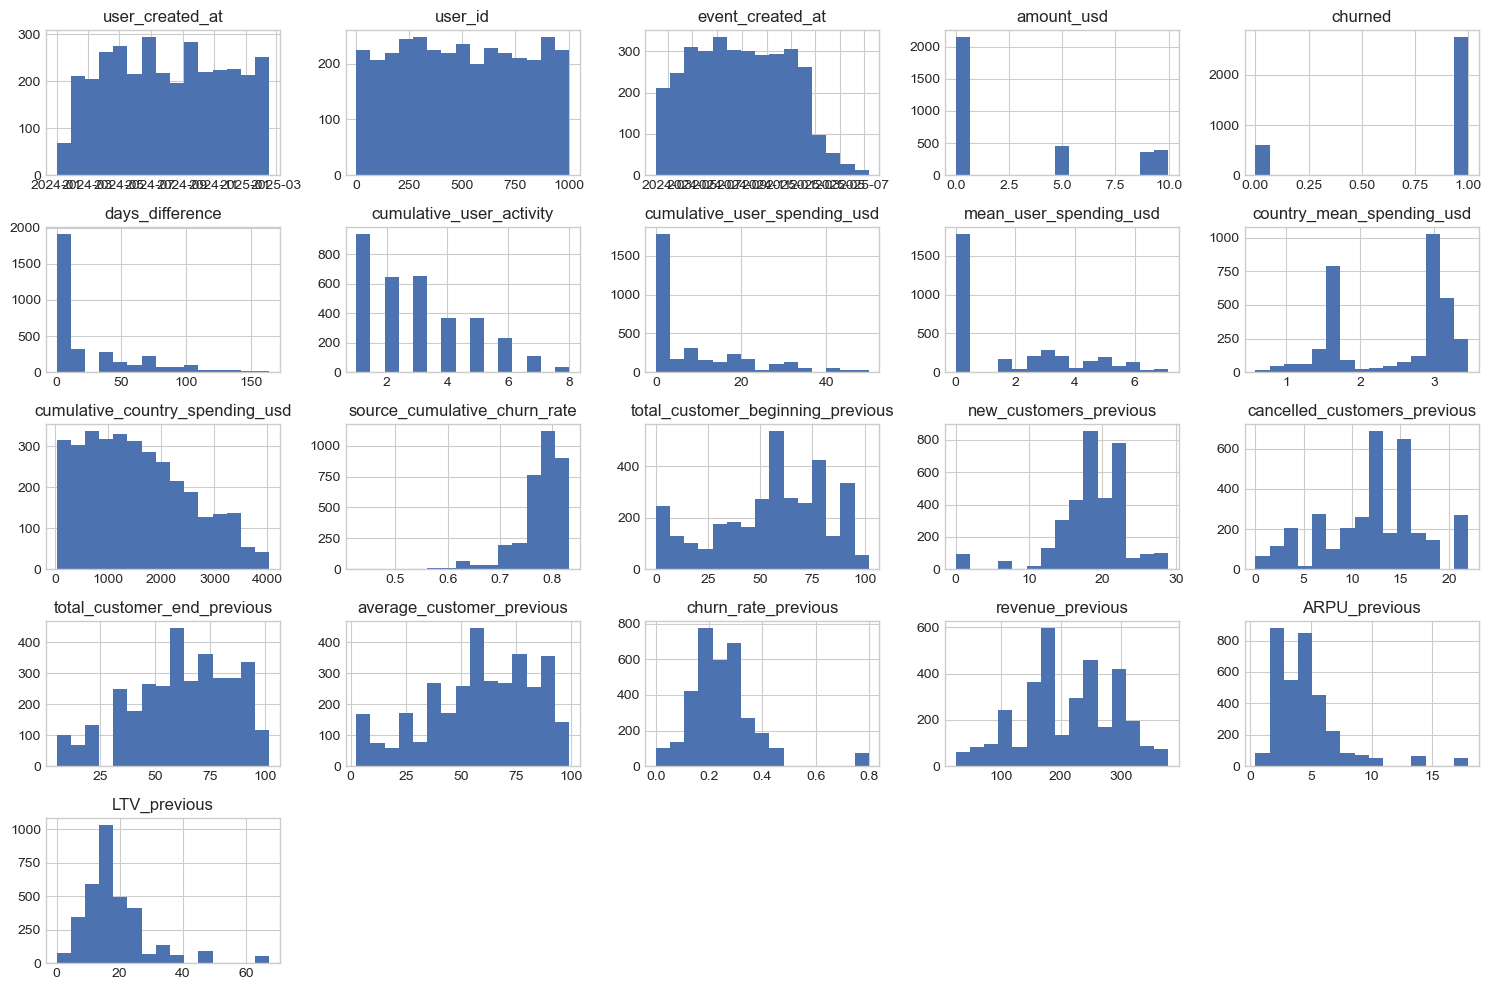

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for all numerical columns
merged_df.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()


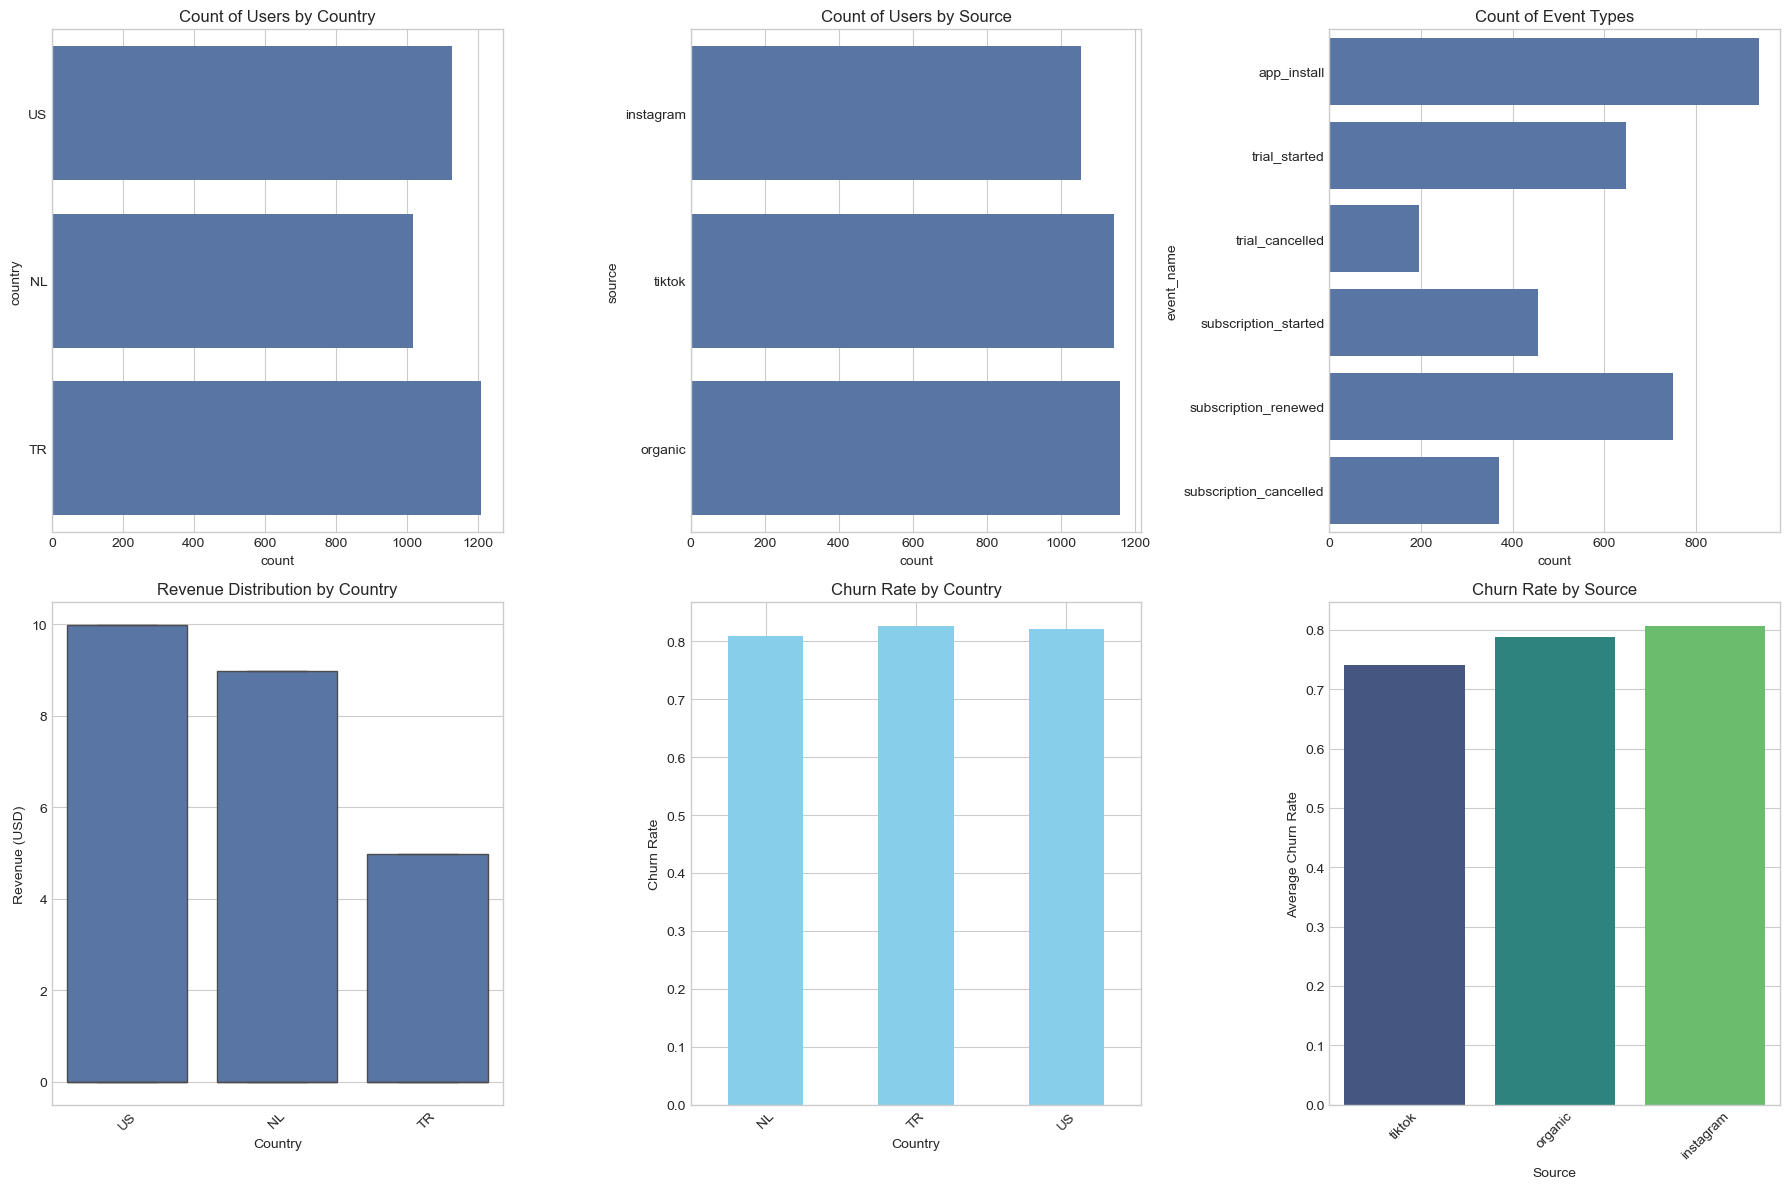

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate churn rate by source
churn_by_source = merged_df.groupby('source')['source_cumulative_churn_rate'].mean().sort_values()

# Create a figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Count plot for 'country'
sns.countplot(y='country', data=merged_df, ax=axes[0, 0])
axes[0, 0].set_title('Count of Users by Country')

# Count plot for 'source'
sns.countplot(y='source', data=merged_df, ax=axes[0, 1])
axes[0, 1].set_title('Count of Users by Source')

# Count plot for 'event_name'
sns.countplot(y='event_name', data=merged_df, ax=axes[0, 2])
axes[0, 2].set_title('Count of Event Types')

# Boxplot for Revenue Distribution by Country
sns.boxplot(x='country', y='amount_usd', data=merged_df, ax=axes[1, 0])
axes[1, 0].set_title("Revenue Distribution by Country")
axes[1, 0].set_xlabel("Country")
axes[1, 0].set_ylabel("Revenue (USD)")
axes[1, 0].tick_params(axis='x', rotation=45)

# Churn Rate by Country (Bar Plot)
churn_rate_by_country = merged_df.groupby('country')['churned'].mean()
churn_rate_by_country.plot(kind='bar', color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('Churn Rate by Country')
axes[1, 1].set_xlabel('Country')
axes[1, 1].set_ylabel('Churn Rate')
axes[1, 1].tick_params(axis='x', rotation=45)

# Churn Rate by Source (Bar Plot)
sns.barplot(
    x=churn_by_source.index, 
    y=churn_by_source.values, 
    hue=churn_by_source.index,  
    palette="viridis",
    legend=False,
    ax=axes[1, 2]  # Assign to the last subplot
)
axes[1, 2].set_title("Churn Rate by Source")
axes[1, 2].set_xlabel("Source")
axes[1, 2].set_ylabel("Average Churn Rate")
axes[1, 2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


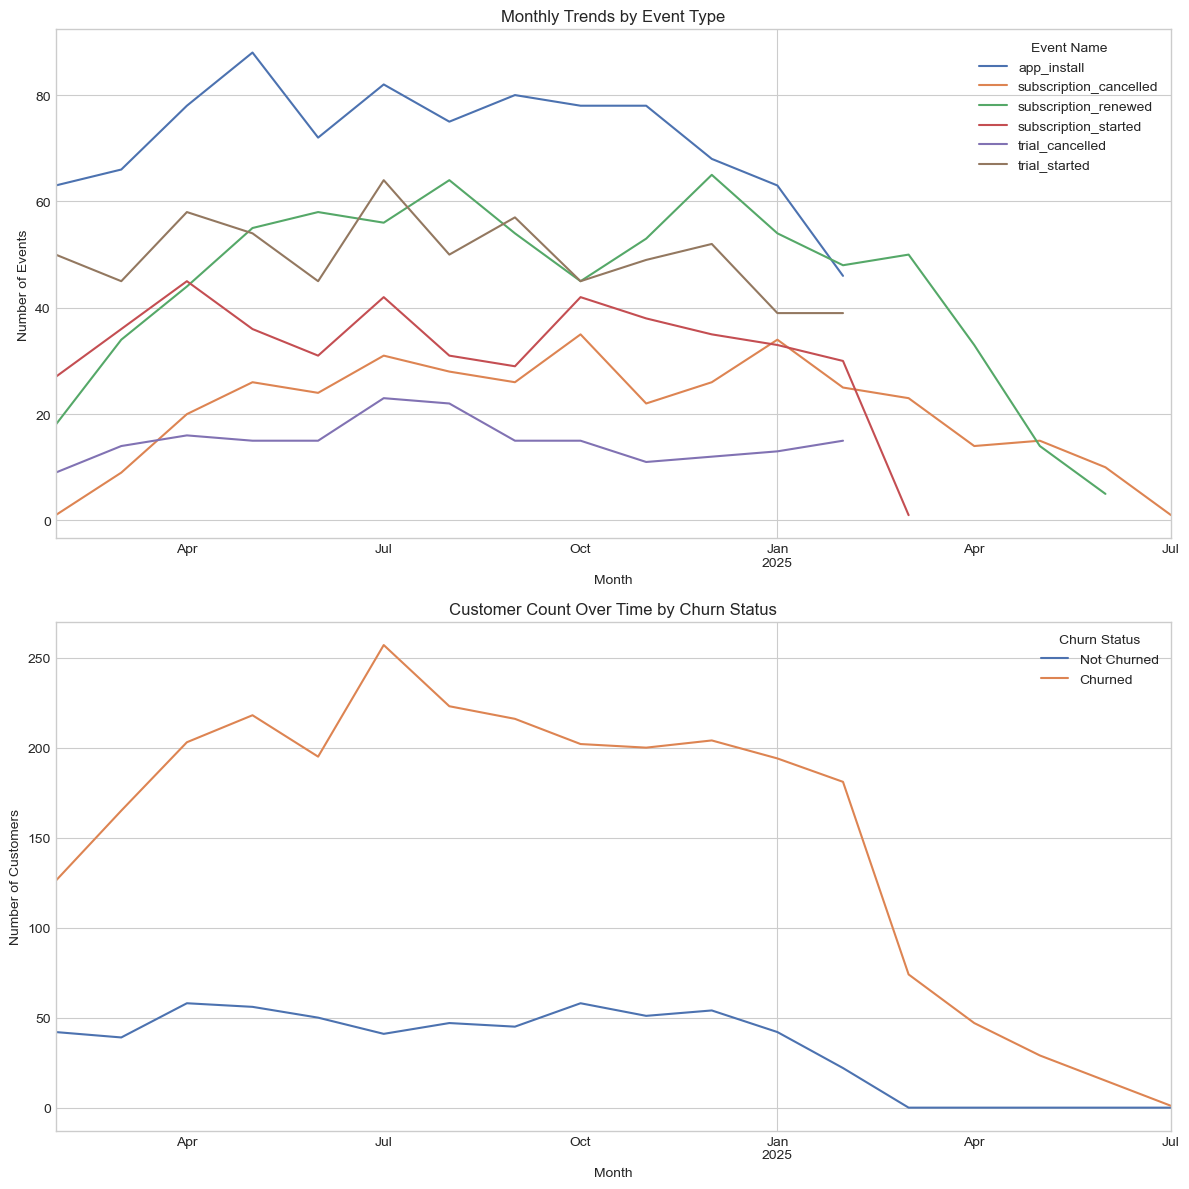

In [71]:
merged_df['event_created_at'] = pd.to_datetime(merged_df['event_created_at'])

# Monthly Trends by Event Type
event_trends = merged_df.set_index('event_created_at').groupby('event_name')['user_id'].resample('M').count().unstack('event_name')

# Customer Count Over Time by Churn Status
customer_counts = merged_df.groupby([pd.Grouper(key='event_created_at', freq='M'), 'churned']).size().unstack(fill_value=0)

# Create a figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Monthly Trends by Event Type
event_trends.plot(ax=axes[0])
axes[0].set_title('Monthly Trends by Event Type')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Events')
axes[0].legend(title='Event Name')
axes[0].grid(True)

# Plot 2: Customer Count Over Time by Churn Status
customer_counts.plot(kind='line', ax=axes[1])
axes[1].set_title('Customer Count Over Time by Churn Status')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Customers')
axes[1].legend(title='Churn Status', labels=['Not Churned', 'Churned'])
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [72]:
merged_df['signup_cohort'] = merged_df['user_created_at'].dt.to_period('M')

# Analyzing customer retention by cohort
cohort_data = merged_df.groupby(['signup_cohort', 'churned']).size().unstack()
cohort_data = cohort_data.divide(cohort_data.sum(axis=1), axis=0)  # Normalize by total customers in each cohort

# Plotting cohort data
cohort_data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Customer Retention by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Proportion of Customers')
plt.legend(title='Churn Status', labels=['Not Churned', 'Churned'])
plt.show()
merged_df=merged_df.drop(columns="signup_cohort")

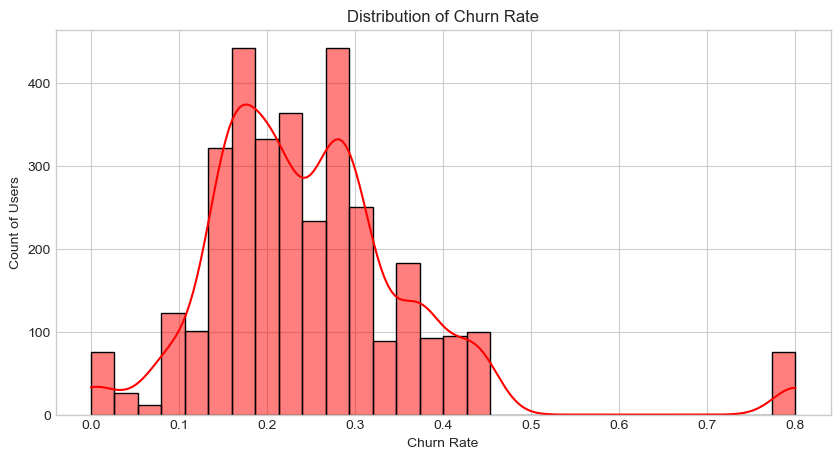

In [73]:
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['churn_rate_previous'], bins=30, kde=True, color='red')
plt.title("Distribution of Churn Rate")
plt.xlabel("Churn Rate")
plt.ylabel("Count of Users")
plt.grid(True)
plt.show()


In [74]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ARPU vs. Churn Rate (Left)
sns.scatterplot(x=merged_df['churn_rate_previous'], y=merged_df['ARPU_previous'], alpha=0.6, color='green', ax=axes[0])
axes[0].set_title("ARPU vs. Churn Rate")
axes[0].set_xlabel("Churn Rate")
axes[0].set_ylabel("ARPU (Average Revenue Per User)")
axes[0].grid(True)

# Revenue vs. Churn Rate (Right)
sns.scatterplot(x=merged_df['churn_rate_previous'], y=merged_df['revenue_previous'], alpha=0.6, color='blue', ax=axes[1])
axes[1].set_title("Revenue vs. Churn Rate")
axes[1].set_xlabel("Churn Rate")
axes[1].set_ylabel("Revenue")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [75]:
# Convert to datetime (if not already)
merged_df['user_created_at'] = pd.to_datetime(merged_df['user_created_at'])
merged_df['event_created_at'] = pd.to_datetime(merged_df['event_created_at'])

# User Signup Growth
signup_growth = merged_df.groupby(merged_df['user_created_at'].dt.date)['user_id'].nunique().sort_index()

# User Activity Growth
activity_growth = merged_df.groupby(merged_df['event_created_at'].dt.date)['user_id'].nunique().sort_index()

# Revenue Trend
revenue_trend = merged_df.groupby(merged_df['event_created_at'].dt.date)['amount_usd'].sum()

# Create a figure with 3 subplots (stacked vertically)
fig, axes = plt.subplots(3, 1, figsize=(12, 14))  

# Plot 1: User Signups Over Time
sns.lineplot(x=signup_growth.index, y=signup_growth.values, marker='o', color='b', ax=axes[0])
axes[0].set_title("User Signups Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Unique Signups")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# Plot 2: User Activity Over Time
sns.lineplot(x=activity_growth.index, y=activity_growth.values, marker='o', color='g', ax=axes[1])
axes[1].set_title("User Activity Over Time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Unique Active Users")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

# Plot 3: Revenue Trend Over Time
sns.lineplot(x=revenue_trend.index, y=revenue_trend.values, marker='o', color='r', ax=axes[2])
axes[2].set_title("Revenue Trend Over Time")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Revenue (USD)")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


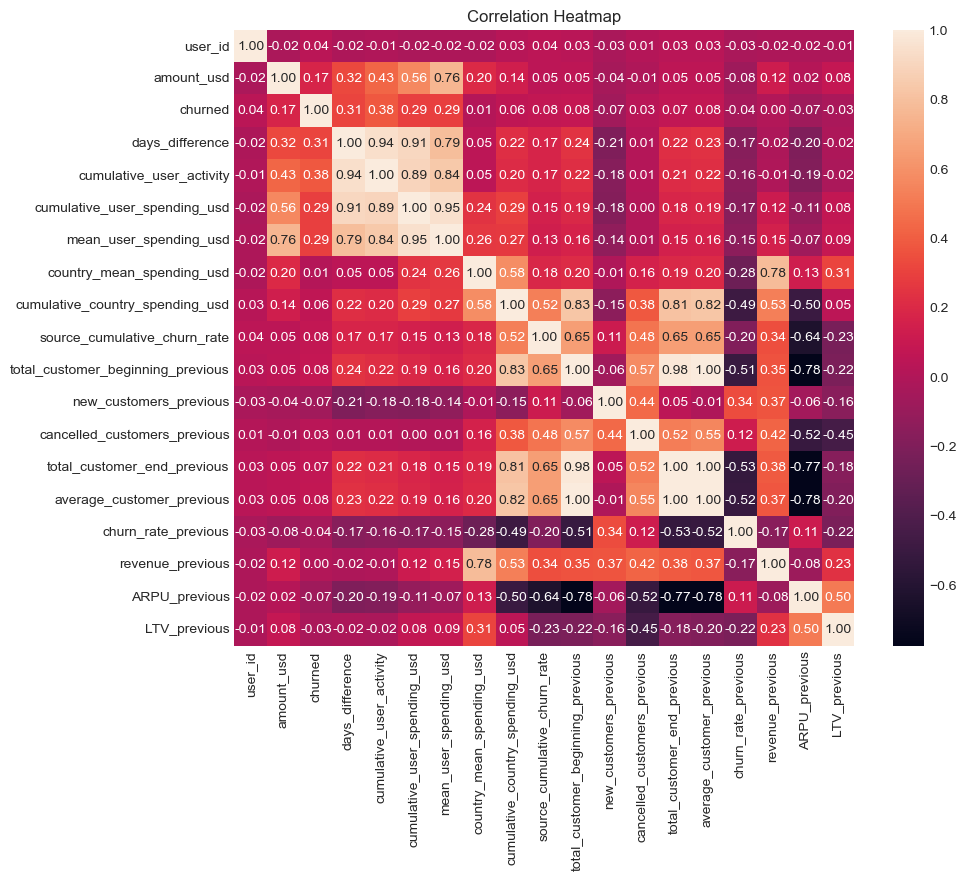

In [76]:
# Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


### Data Preparation:

### Converting Categorical Values into Numerical Values:

In [91]:
df_new=merged_df

In [92]:
df_new = pd.get_dummies(df_new, columns=['country', 'source', 'event_name'])

In [93]:
# Exclude datetime columns from the conversion
non_datetime_columns = df_new.select_dtypes(exclude=['datetime']).columns
df_new[non_datetime_columns] = df_new[non_datetime_columns].astype(int)


In [94]:
df_new

user_created_at  user_id event_created_at  amount_usd  churned  \
0         2024-05-07        1       2024-05-07           0        1   
1         2024-05-07        1       2024-05-12           0        1   
2         2024-05-07        1       2024-05-24           0        1   
3         2024-10-12        2       2024-10-12           0        1   
4         2024-10-12        2       2024-10-13           0        1   
...              ...      ...              ...         ...      ...   
3350      2025-02-13     1000       2025-02-25           0        1   
3351      2025-02-16     1001       2025-02-25           0        0   
3352      2025-02-16     1001       2025-02-25           9        0   
3353      2025-02-16     1001       2025-02-25           0        0   
3354      2025-02-16     1002       2025-02-25           0        0   

      days_difference  cumulative_user_activity  cumulative_user_spending_usd  \
0                   0                         1                             0   
1                   5                         2                             0   
2                  17                         3                             0   
3                   0                         1                             0   
4                   1                         2                             0   
...               ...                       ...                           ...   
3350               12                         3                             0   
3351                9                         3                             9   
3352                9                         3                             9   
3353                9                         3                             9   
3354                9                         1                             0   

      mean_user_spending_usd  country_mean_spending_usd  \
0                          0                          3   
1                          0                          2   
2                          0                          2   
3                          0                          3   
4                          0                          3   
...                      ...                        ...   
3350                       0                          3   
3351                       3                          3   
3352                       3                          3   
3353                       3                          3   
3354                       0                          1   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
0                                 849                             0   
1                                 869                             0   
2                                 979                             0   
3                                2094                             0   
4                                2103                             0   
...                               ...                           ...   
3350                             3173                             0   
3351                             3706                             0   
3352                             3706                             0   
3353                             3706                             0   
3354                             1991                             0   

      total_customer_beginning_previous  new_customers_previous  \
0                                    40                      18   
1                                    40                      18   
2                                    40                      18   
3                                    59                      18   
4                                    59                      18   
...                                 ...                     ...   
3350                                 91                      18   
3351                                 93                      12   
3352          

In [95]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   user_created_at                    3355 non-null   datetime64[ns]
 1   user_id                            3355 non-null   int32         
 2   event_created_at                   3355 non-null   datetime64[ns]
 3   amount_usd                         3355 non-null   int32         
 4   churned                            3355 non-null   int32         
 5   days_difference                    3355 non-null   int32         
 6   cumulative_user_activity           3355 non-null   int32         
 7   cumulative_user_spending_usd       3355 non-null   int32         
 8   mean_user_spending_usd             3355 non-null   int32         
 9   country_mean_spending_usd          3355 non-null   int32         
 10  cumulative_country_spending_usd    3

In [96]:
df_new['user_created_at'] = pd.to_datetime(df_new['user_created_at'])
df_new['event_created_at'] = pd.to_datetime(df_new['event_created_at'])

# Extract features
df_new['user_signup_year'] = df_new['user_created_at'].dt.year
df_new['user_signup_month'] = df_new['user_created_at'].dt.month
df_new['user_signup_day'] = df_new['user_created_at'].dt.day
df_new['user_signup_weekday'] = df_new['user_created_at'].dt.weekday  # Monday=0, Sunday=6

df_new['event_year'] = df_new['event_created_at'].dt.year
df_new['event_month'] = df_new['event_created_at'].dt.month
df_new['event_day'] = df_new['event_created_at'].dt.day
df_new['event_weekday'] = df_new['event_created_at'].dt.weekday


In [97]:
# Convert month and weekday into cyclical features
df_new['signup_month_sin'] = np.sin(2 * np.pi * df_new['user_signup_month']/12)
df_new['signup_month_cos'] = np.cos(2 * np.pi * df_new['user_signup_month']/12)
df_new['signup_weekday_sin'] = np.sin(2 * np.pi * df_new['user_signup_weekday']/7)
df_new['signup_weekday_cos'] = np.cos(2 * np.pi * df_new['user_signup_weekday']/7)

df_new['event_month_sin'] = np.sin(2 * np.pi * df_new['event_month']/12)
df_new['event_month_cos'] = np.cos(2 * np.pi * df_new['event_month']/12)
df_new['event_weekday_sin'] = np.sin(2 * np.pi * df_new['event_weekday']/7)
df_new['event_weekday_cos'] = np.cos(2 * np.pi * df_new['event_weekday']/7)


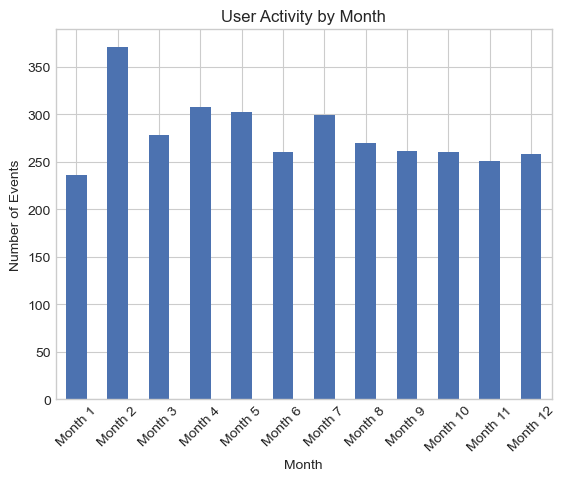

In [98]:
# Extracting day of week and month for event creation
df_new['day_of_week'] = df_new['event_created_at'].dt.dayofweek
df_new['month'] = df_new['event_created_at'].dt.month

# Analyzing weekly patterns
weekly_pattern = df_new.groupby('day_of_week').size()
weekly_pattern.plot(kind='bar')
plt.title('User Activity by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Events')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

# Analyzing monthly patterns
monthly_pattern = df_new.groupby('month').size()
monthly_pattern.plot(kind='bar')
plt.title('User Activity by Month')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.xticks(ticks=range(12), labels=[f'Month {i+1}' for i in range(12)], rotation=45)
plt.show()


In [99]:
print("Churned data count: ", len(df_new[df_new.churned==1]))
print("not Churned data count:", len(df_new[df_new.churned==0]))

Churned data count:  2750
not Churned data count: 605


In [100]:
# Plot class distribution
sns.countplot(x=df_new['churned'])
plt.title("Churned vs. Not Churned Distribution")
plt.xlabel("Churned (1) vs Not Churned (0)")
plt.ylabel("Count")
plt.show()


Since the data is imbalance, the model which will be trained won't work properly. In this case, I will apply oversampling for the minority (not churned) data and under simple the majority (churned) data as there is a huge difference. To oversample the not churned data to make the counts equal might not work properly due to the count difference each other.

Addition to this, some columns must be scaled. I would like to use standard scaling. Besides that, the data must have less dimension. Because having more than specific number of columns doesn't change the model robustness. In order to do that, PCA(Princial Component Analysis) will be applied by keeping 95% of the variance. In that way, the meaning of the data will be kept while decreasing the amount of the data.

Also, I wouldn't like to go with hyperparameter optimization since it's another topic that must be deal with. However, it can be done for further processes.

In [101]:
df_new

user_created_at  user_id event_created_at  amount_usd  churned  \
0         2024-05-07        1       2024-05-07           0        1   
1         2024-05-07        1       2024-05-12           0        1   
2         2024-05-07        1       2024-05-24           0        1   
3         2024-10-12        2       2024-10-12           0        1   
4         2024-10-12        2       2024-10-13           0        1   
...              ...      ...              ...         ...      ...   
3350      2025-02-13     1000       2025-02-25           0        1   
3351      2025-02-16     1001       2025-02-25           0        0   
3352      2025-02-16     1001       2025-02-25           9        0   
3353      2025-02-16     1001       2025-02-25           0        0   
3354      2025-02-16     1002       2025-02-25           0        0   

      days_difference  cumulative_user_activity  cumulative_user_spending_usd  \
0                   0                         1                             0   
1                   5                         2                             0   
2                  17                         3                             0   
3                   0                         1                             0   
4                   1                         2                             0   
...               ...                       ...                           ...   
3350               12                         3                             0   
3351                9                         3                             9   
3352                9                         3                             9   
3353                9                         3                             9   
3354                9                         1                             0   

      mean_user_spending_usd  country_mean_spending_usd  \
0                          0                          3   
1                          0                          2   
2                          0                          2   
3                          0                          3   
4                          0                          3   
...                      ...                        ...   
3350                       0                          3   
3351                       3                          3   
3352                       3                          3   
3353                       3                          3   
3354                       0                          1   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
0                                 849                             0   
1                                 869                             0   
2                                 979                             0   
3                                2094                             0   
4                                2103                             0   
...                               ...                           ...   
3350                             3173                             0   
3351                             3706                             0   
3352                             3706                             0   
3353                             3706                             0   
3354                             1991                             0   

      total_customer_beginning_previous  new_customers_previous  \
0                                    40                      18   
1                                    40                      18   
2                                    40                      18   
3                                    59                      18   
4                                    59                      18   
...                                 ...                     ...   
3350                                 91                      18   
3351                                 93                      12   
3352          

In [102]:
df_final=df_new

In [91]:
from sklearn.preprocessing import StandardScaler

# Select the columns to normalize
columns_to_scale = [
    "amount_usd", "days_difference", "cumulative_user_activity", 
    "cumulative_user_spending_usd", "mean_user_spending_usd", 
    "country_mean_spending_usd", "cumulative_country_spending_usd", 
    "source_cumulative_churn_rate", "total_customer_beginning_previous",
    "new_customers_previous", "cancelled_customers_previous", 
    "total_customer_end_previous", "average_customer_previous", 
    "churn_rate_previous", "revenue_previous", "ARPU_previous", "LTV_previous",
    "signup_month_sin", "signup_month_cos", "signup_weekday_sin", "signup_weekday_cos",
    "event_month_sin", "event_month_cos", "event_weekday_sin", "event_weekday_cos"
]

# Apply StandardScaler
scaler = StandardScaler()
df_final[columns_to_scale] = scaler.fit_transform(df_final[columns_to_scale])

df_final


user_created_at  user_id event_created_at  amount_usd  churned  \
0         2024-05-07        1       2024-05-07   -0.693920        1   
1         2024-05-07        1       2024-05-12   -0.693920        1   
2         2024-05-07        1       2024-05-24   -0.693920        1   
3         2024-10-12        2       2024-10-12   -0.693920        1   
4         2024-10-12        2       2024-10-13   -0.693920        1   
...              ...      ...              ...         ...      ...   
3350      2025-02-13     1000       2025-02-25   -0.693920        1   
3351      2025-02-16     1001       2025-02-25   -0.693920        0   
3352      2025-02-16     1001       2025-02-25    1.849219        0   
3353      2025-02-16     1001       2025-02-25   -0.693920        0   
3354      2025-02-16     1002       2025-02-25   -0.693920        0   

      days_difference  cumulative_user_activity  cumulative_user_spending_usd  \
0           -0.727040                 -1.090192                     -0.721615   
1           -0.589281                 -0.538019                     -0.721615   
2           -0.258659                  0.014154                     -0.721615   
3           -0.727040                 -1.090192                     -0.721615   
4           -0.699488                 -0.538019                     -0.721615   
...               ...                       ...                           ...   
3350        -0.396418                  0.014154                     -0.721615   
3351        -0.479073                  0.014154                      0.090232   
3352        -0.479073                  0.014154                      0.090232   
3353        -0.479073                  0.014154                      0.090232   
3354        -0.479073                 -1.090192                     -0.721615   

      mean_user_spending_usd  country_mean_spending_usd  \
0                  -0.796707                   1.039331   
1                  -0.796707                  -0.044247   
2                  -0.796707                  -0.044247   
3                  -0.796707                   1.039331   
4                  -0.796707                   1.039331   
...                      ...                        ...   
3350               -0.796707                   1.039331   
3351                0.857347                   1.039331   
3352                0.857347                   1.039331   
3353                0.857347                   1.039331   
3354               -0.796707                  -1.127826   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
0                           -0.710920                           0.0   
1                           -0.690471                           0.0   
2                           -0.578000                           0.0   
3                            0.562040                           0.0   
4                            0.571243                           0.0   
...                               ...                           ...   
3350                         1.665273                           0.0   
3351                         2.210243                           0.0   
3352                         2.210243                           0.0   
3353                         2.210243                           0.0   
3354                         0.456727                           0.0   

      total_customer_beginning_previous  new_customers_previous  \
0                             -0.578579               -0.161010   
1                             -0.578579               -0.161010   
2                             -0.578579               -0.161010   
3                              0.144347               -0.161010   
4                              0.144347               -0.161010   
...                                 ...                     ...   
3350                           1.361907               -0.161010   
3351                           1.438004               -1.354353   
3352          

In [94]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(df_final[columns_to_scale])

# Convert PCA-transformed data back into a DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_pca['churned'] = df_final['churned'].values  # Add target variable back

# Print explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"üîπ Total Variance Retained: {explained_variance:.4f}")
print(f"üîπ Number of Principal Components Selected: {pca.n_components_}")

# Display transformed dataset
df_pca.head()

üîπ Total Variance Retained: 0.9528
üîπ Number of Principal Components Selected: 12


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.941317 -1.205766 -1.154129  0.343570  1.934123  0.277286 -1.694422   
1 -1.995990 -0.959841 -1.075030 -0.360257  1.027568 -0.914508 -1.203109   
2 -1.814562 -0.610700 -1.157175 -0.471117 -0.000185  0.258361 -1.364876   
3  0.588901 -1.963030  0.712098  1.247810 -1.631956 -1.278612  0.933844   
4  0.694979 -1.735537  0.672435  1.142510 -0.829086 -1.618530  0.993919   

        PC8       PC9      PC10      PC11      PC12  churned  
0  0.230442 -0.066324 -0.342704 -0.410954 -0.876980        1  
1  0.380078  1.462198  0.148436 -0.592199 -0.551653        1  
2  0.420750  0.701032  1.488013 -0.960743 -0.727312        1  
3 -1.065984 -0.059107 -0.103609 -0.410125 -0.359858        1  
4 -1.296030  0.051035 -0.773970  0.097326 -0.323066        1

## Classification:

I will try different models and make comparison. After that, I will choose the best model among them.

In [96]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Step 1: Define X (features) and y (target)
X = df_final.drop(['churned', 'user_created_at', 'event_created_at', 'user_id'], axis=1)  # Drop non-predictive columns
y = df_final['churned']  # Target variable

# Step 2: Train-Test Split (Before Balancing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Undersample Churned Users (Keep a portion of them)
undersample = RandomUnderSampler(sampling_strategy=0.65, random_state=42)  
X_under, y_under = undersample.fit_resample(X_train, y_train)

# Step 4: Oversample Non-Churned Users (Using SMOTE)
smote = SMOTE(sampling_strategy=0.8, random_state=42) 
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

# Check new class distribution
print("New class distribution after hybrid balancing:")
print("Churned count:", sum(y_resampled == 1))
print("Not Churned count:", sum(y_resampled == 0))

New class distribution after hybrid balancing:
Churned count: 744
Not Churned count: 595


In [97]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Support Vector Machine (SVM)": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=5)
}

# Dictionary to store model evaluation results
model_metrics = {}

# Use tqdm to show progress bar
for name, model in tqdm(models.items(), desc="Training and Evaluating Models", unit="model"):
    # Train the model
    model.fit(X_resampled, y_resampled)
    
    # Make predictions
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]  # Probability for class 1 (churn)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)
    
    # Store results
    model_metrics[name] = {
        "Accuracy": accuracy,
        "ROC-AUC Score": roc_auc,
        "Classification Report": classification_report(y_test, predictions, output_dict=True)
    }
    
    print(f"\nüîπ {name} Performance:")
    print(f"   - Accuracy: {accuracy:.4f}")
    print(f"   - ROC-AUC Score: {roc_auc:.4f}")

Training and Evaluating Models:   0%|                                                         | 0/6 [00:00<?, ?model/s]C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training and Evaluating Models:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 1/6 [00:00<00:01,  4.65model/s]


üîπ Logistic Regression Performance:
   - Accuracy: 0.7347
   - ROC-AUC Score: 0.8038


Training and Evaluating Models:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                | 2/6 [00:00<00:01,  3.60model/s]


üîπ Random Forest Performance:
   - Accuracy: 0.7124
   - ROC-AUC Score: 0.7576


Training and Evaluating Models:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                        | 3/6 [00:00<00:01,  2.99model/s]


üîπ Gradient Boosting Performance:
   - Accuracy: 0.7213
   - ROC-AUC Score: 0.7985


C:\Users\Mert\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:46:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Training and Evaluating Models:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 4/6 [00:02<00:01,  1.45model/s]


üîπ XGBoost Performance:
   - Accuracy: 0.7258
   - ROC-AUC Score: 0.7968


C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Training and Evaluating Models: 100%|‚ñà‚ñà


üîπ Support Vector Machine (SVM) Performance:
   - Accuracy: 0.8197
   - ROC-AUC Score: 0.7222

üîπ K-Nearest Neighbors (KNN) Performance:
   - Accuracy: 0.6796
   - ROC-AUC Score: 0.7155


In [99]:
# Extract precision, recall, f1-score, accuracy, and ROC-AUC score from classification reports
classification_metrics = {}

for model, metrics in model_metrics.items():
    report_dict = metrics["Classification Report"]
    
    # Extract macro average values
    precision = report_dict["macro avg"]["precision"]
    recall = report_dict["macro avg"]["recall"]
    f1_score = report_dict["macro avg"]["f1-score"]
    
    # Extract accuracy and ROC-AUC score
    accuracy = metrics["Accuracy"]
    roc_auc = metrics["ROC-AUC Score"]
    
    # Store values
    classification_metrics[model] = {
        "Accuracy": round(accuracy, 4),
        "ROC-AUC Score": round(roc_auc, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1_score, 4)
    }

# Convert extracted classification metrics into a DataFrame
df_classification_metrics = pd.DataFrame(classification_metrics).T
df_classification_metrics

Accuracy  ROC-AUC Score  Precision  Recall  \
Logistic Regression             0.7347         0.8038     0.6616  0.7544   
Random Forest                   0.7124         0.7576     0.6095  0.6602   
Gradient Boosting               0.7213         0.7985     0.6356  0.7075   
XGBoost                         0.7258         0.7968     0.6243  0.6812   
Support Vector Machine (SVM)    0.8197         0.7222     0.4098  0.5000   
K-Nearest Neighbors (KNN)       0.6796         0.7155     0.5981  0.6531   

                              F1-Score  
Logistic Regression             0.6668  
Random Forest                   0.6146  
Gradient Boosting               0.6406  
XGBoost                         0.6318  
Support Vector Machine (SVM)    0.4505  
K-Nearest Neighbors (KNN)       0.5941

## Weighted Ensemble Probability Result

In [100]:
# Extract user #1002's data
user_1002 = df_final[df_final['user_id'] == 1002].drop(['churned', 'user_created_at', 'event_created_at', 'user_id'], axis=1)

# Ensure missing columns from X_train are added to user_1002
missing_cols = set(X_train.columns) - set(user_1002.columns)
for col in missing_cols:
    user_1002[col] = 0  

# Reorder columns to match training set
user_1002 = user_1002[X_train.columns]

# Predict churn probability using all models
clark_kent_predictions = {}

# Use tqdm for progress bar
for name, model in tqdm(models.items(), desc="Predicting Churn for Clark Kent", unit="model"):
    churn_probability = model.predict_proba(user_1002)[:, 1][0]
    clark_kent_predictions[name] = churn_probability

# Print churn probability predictions
print("\nüîπ Predicted Churn Probability for User #1002 (Clark Kent):")
for model_name, prob in clark_kent_predictions.items():
    print(f"   - {model_name}: {prob:.4f}")

# Define ROC-AUC Scores (used as weights)
roc_auc_scores = {
    "Logistic Regression": 0.8018,
    "Random Forest": 0.7549,
    "Gradient Boosting": 0.7966,
    "XGBoost": 0.7960,
    "Support Vector Machine (SVM)": 0.5697,
    "K-Nearest Neighbors (KNN)": 0.7063
}

# Compute weighted average
weighted_sum = sum(roc_auc_scores[model] * clark_kent_predictions[model] for model in clark_kent_predictions)
total_weight = sum(roc_auc_scores.values())

ensemble_probability = weighted_sum / total_weight  # Weighted average formula

# Display final result
print(f"\nüîπ Weighted Ensemble Churn Probability for User #1002 (Clark Kent): {ensemble_probability:.4f}")

Predicting Churn for Clark Kent: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:00<00:00, 130.50model/s]


üîπ Predicted Churn Probability for User #1002 (Clark Kent):
   - Logistic Regression: 0.3398
   - Random Forest: 0.2633
   - Gradient Boosting: 0.1653
   - XGBoost: 0.0253
   - Support Vector Machine (SVM): 0.7293
   - K-Nearest Neighbors (KNN): 0.0000

üîπ Weighted Ensemble Churn Probability for User #1002 (Clark Kent): 0.2347


It can be seen that the churn probability of the user is 23.47%, so it's unlikely that the user churnes.

# **Question 8: Predicting Potential Lifetime Value (pLTV) for User #1001 (Bruce Wayne)**

## **Model Selection & Feature Engineering Process**

To predict LTV, both traditional and advanced models were tested:

- **Basic Models:** Linear Regression, Ridge/Lasso (for feature selection), Polynomial Regression.
- **Ensemble Models:** Random Forest, Gradient Boosting, XGBoost.
- **Deep Learning:** LSTM (Long Short-Term Memory) to capture sequential user spending patterns.

### **Feature Engineering Steps:**

- **Financial Features:**
  - `cumulative_user_spending_usd`: Total amount spent.
  - `mean_user_spending_usd`: Average spending per transaction.
  - `LTV_previous`: Prior estimated LTV.

- **User Behavior Features:**
  - `cumulative_user_activity`: Measures engagement over time.
  - `days_difference`: Days between signup and current event.

- **Churn & Subscription Trends:**
  - `churn_rate_previous`: Country-level churn rate trends.
  - `ARPU_previous`: Average revenue per user.

---

## **Methodology & Assumptions**

### **1. Churned Users vs. Active Users**
- Churned users have a known final LTV.
- Active users require a **predicted** LTV.

### **2. LTV Prediction Formulation**
$$
LTV = \frac{ARPU}{\text{Churn Rate}}
$$
Where:
- **ARPU** = Average Revenue Per User.
- **Churn Rate** = Probability of user canceling the service.

### **3. Handling Multiple User Events**
- Users may have multiple transactions, so their **final LTV** is estimated by averaging predictions across multiple records.

---

## **Final Weighted Prediction**

To ensure reliability, predictions from multiple models were **weighted** based on their performance (MAE and RMSE):

$$
P_{LTV} = \frac{\sum \frac{1}{\text{RMSE}_i} \times P_i}{\sum \frac{1}{\text{RMSE}_i}}
$$

Where:
- \( P_i \) is the LTV prediction from model \( i \).
- \( RMSE_i \) is the model‚Äôs root mean squared error.

This approach ensures that **lower-error models contribute more to the final prediction**.

üîπ **The final predicted LTV for User #1001 (Bruce Wayne) was obtained using this ensemble method.**


Since the lifetime value of the non-churned users is not exact, I will exclude non-churned users to build a model. At the end, I will take the relevant user and make prediciton.

In [117]:
df8=df_new

In [118]:
df8

user_created_at  user_id event_created_at  amount_usd  churned  \
0         2024-05-07        1       2024-05-07           0        1   
1         2024-05-07        1       2024-05-12           0        1   
2         2024-05-07        1       2024-05-24           0        1   
3         2024-10-12        2       2024-10-12           0        1   
4         2024-10-12        2       2024-10-13           0        1   
...              ...      ...              ...         ...      ...   
3350      2025-02-13     1000       2025-02-25           0        1   
3351      2025-02-16     1001       2025-02-25           0        0   
3352      2025-02-16     1001       2025-02-25           9        0   
3353      2025-02-16     1001       2025-02-25           0        0   
3354      2025-02-16     1002       2025-02-25           0        0   

      days_difference  cumulative_user_activity  cumulative_user_spending_usd  \
0                   0                         1                             0   
1                   5                         2                             0   
2                  17                         3                             0   
3                   0                         1                             0   
4                   1                         2                             0   
...               ...                       ...                           ...   
3350               12                         3                             0   
3351                9                         3                             9   
3352                9                         3                             9   
3353                9                         3                             9   
3354                9                         1                             0   

      mean_user_spending_usd  country_mean_spending_usd  \
0                          0                          3   
1                          0                          2   
2                          0                          2   
3                          0                          3   
4                          0                          3   
...                      ...                        ...   
3350                       0                          3   
3351                       3                          3   
3352                       3                          3   
3353                       3                          3   
3354                       0                          1   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
0                                 849                             0   
1                                 869                             0   
2                                 979                             0   
3                                2094                             0   
4                                2103                             0   
...                               ...                           ...   
3350                             3173                             0   
3351                             3706                             0   
3352                             3706                             0   
3353                             3706                             0   
3354                             1991                             0   

      total_customer_beginning_previous  new_customers_previous  \
0                                    40                      18   
1                                    40                      18   
2                                    40                      18   
3                                    59                      18   
4                                    59                      18   
...                                 ...                     ...   
3350                                 91                      18   
3351                                 93                      12   
3352          

In [119]:
# Get the final LTV (max LTV_previous) for churned users
final_LTV_per_user = df8[df8["churned"] == 1].groupby("user_id")["LTV_previous"].max().reset_index()

# Rename the column
final_LTV_per_user.rename(columns={"LTV_previous": "final_LTV"}, inplace=True)


In [120]:
final_LTV_per_user

user_id  final_LTV
0          1         12
1          2         23
2          3         15
3          4         13
4          6          5
..       ...        ...
560      995         45
561      996         19
562      997         37
563      999         18
564     1000         17

[565 rows x 2 columns]

In [121]:
# Merge the final_LTV_per_user with df8 (on user_id)
df8 = df8.merge(final_LTV_per_user, on="user_id", how="left")

# Fill NaN values with 0 (for non-churned users who do not have a final LTV)
df8["final_LTV"] = df8["final_LTV"].fillna(0)


In [122]:
df8_nonchurned=df8[df8.churned==0].reset_index(drop=True)

In [123]:
df8=df8[df8.churned==1].reset_index(drop=True)

In [124]:
df8

user_created_at  user_id event_created_at  amount_usd  churned  \
0         2024-05-07        1       2024-05-07           0        1   
1         2024-05-07        1       2024-05-12           0        1   
2         2024-05-07        1       2024-05-24           0        1   
3         2024-10-12        2       2024-10-12           0        1   
4         2024-10-12        2       2024-10-13           0        1   
...              ...      ...              ...         ...      ...   
2745      2024-12-24      999       2025-03-04           8        1   
2746      2024-12-24      999       2025-03-08           0        1   
2747      2025-02-13     1000       2025-02-13           0        1   
2748      2025-02-13     1000       2025-02-15           0        1   
2749      2025-02-13     1000       2025-02-25           0        1   

      days_difference  cumulative_user_activity  cumulative_user_spending_usd  \
0                   0                         1                             0   
1                   5                         2                             0   
2                  17                         3                             0   
3                   0                         1                             0   
4                   1                         2                             0   
...               ...                       ...                           ...   
2745               70                         5                            26   
2746               74                         6                            26   
2747                0                         1                             0   
2748                2                         2                             0   
2749               12                         3                             0   

      mean_user_spending_usd  country_mean_spending_usd  \
0                          0                          3   
1                          0                          2   
2                          0                          2   
3                          0                          3   
4                          0                          3   
...                      ...                        ...   
2745                       5                          3   
2746                       4                          3   
2747                       0                          3   
2748                       0                          3   
2749                       0                          3   

      cumulative_country_spending_usd  source_cumulative_churn_rate  \
0                                 849                             0   
1                                 869                             0   
2                                 979                             0   
3                                2094                             0   
4                                2103                             0   
...                               ...                           ...   
2745                             3209                             0   
2746                             3227                             0   
2747                             3128                             0   
2748                             3155                             0   
2749                             3173                             0   

      total_customer_beginning_previous  new_customers_previous  \
0                                    40                      18   
1                                    40                      18   
2                                    40                      18   
3                                    59                      18   
4                                    59                      18   
...                                 ...                     ...   
2745                                 94                      10   
2746                                 94                      10   
2747          

In [125]:
# Define X (features) and y (target)
X = df8.drop(['final_LTV', 'user_created_at', 'event_created_at', 'user_id'], axis=1)
y = df8['final_LTV']

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [160]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Define models including a placeholder for LSTM
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (Degree=2)": PolynomialFeatures(degree=2),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Support Vector Regression (SVR)": SVR(kernel='rbf'),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LSTM": None  # Placeholder for LSTM model
}

# Dictionary to store evaluation results
results = {}

for name, model in tqdm(models.items(), desc="Training Models"):
    
    if name == "Polynomial Regression (Degree=2)":
        # Polynomial Regression requires transforming input data
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)

        # Train Linear Regression on transformed data
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_poly, y_train)
        y_pred = lin_reg.predict(X_test_poly)

    elif name == "LSTM":
        # Reshape input data for LSTM (samples, time steps=1, features)
        X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

        # Define LSTM model
        lstm_model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
            LSTM(25, activation='relu', return_sequences=False),  # Last LSTM layer should return False
            Dense(10, activation="relu"),
            Dense(1)  # Output layer for regression
        ])

        # Compile LSTM model
        lstm_model.compile(optimizer="adam", loss="mse")

        # Train LSTM
        history = lstm_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=16, validation_data=(X_test_reshaped, y_test), verbose=1)

        # Save trained model in dictionary
        models["LSTM"] = lstm_model

        # Make predictions
        y_pred = lstm_model.predict(X_test_reshaped).flatten()

    else:
        # Train traditional models
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5

    # Store results
    results[name] = {"MAE": round(mae, 4), "RMSE": round(rmse, 4)}

# Convert results into DataFrame
df_results = pd.DataFrame(results).T

# Display results
df_results


Training Models:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 7/9 [00:03<00:00,  2.08it/s]

Epoch 1/50


C:\Users\Mert\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 5ms/step - loss: 658.9230 - val_loss: 134.9827
Epoch 2/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 123.5061 - val_loss: 84.9552
Epoch 3/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 91.1420 - val_loss: 67.8677
Epoch 4/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 72.7615 - val_loss: 54.8283
Epoch 5/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 52.6837 - val_loss: 41.5295
Epoch 6/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 37.7282 - val_loss: 30.3097
Epoch 7/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 31.2354 - val_loss: 28.9477
Epoch 8/50
138/138 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step - loss: 26.4424 - va

Training Models: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:22<00:00,  2.45s/it]


MAE      RMSE
Linear Regression                  4.7943    6.6150
Polynomial Regression (Degree=2)  17.7154  344.0111
Ridge Regression                   4.8034    6.6599
Lasso Regression                   5.1195    7.2136
Support Vector Regression (SVR)    4.3108    7.3319
Random Forest                      1.5409    3.4943
Gradient Boosting                  2.6159    4.2868
XGBoost                            1.6827    3.3548
LSTM                               2.7253    4.2109

In [187]:
df_results

MAE      RMSE
Linear Regression                  4.7943    6.6150
Polynomial Regression (Degree=2)  17.7154  344.0111
Ridge Regression                   4.8034    6.6599
Lasso Regression                   5.1195    7.2136
Support Vector Regression (SVR)    4.3108    7.3319
Random Forest                      1.5409    3.4943
Gradient Boosting                  2.6159    4.2868
XGBoost                            1.6827    3.3548
LSTM                               2.7253    4.2109

In [196]:
# Extract User #1001‚Äôs data
user_1001 = df8_nonchurned[df8_nonchurned.user_id == 1001].drop(['final_LTV', 'user_created_at', 'event_created_at', 'user_id'], axis=1)
user_1001

amount_usd  churned  days_difference  cumulative_user_activity  \
601           0        0                9                         3   
602           9        0                9                         3   
603           0        0                9                         3   

     cumulative_user_spending_usd  mean_user_spending_usd  \
601                             9                       3   
602                             9                       3   
603                             9                       3   

     country_mean_spending_usd  cumulative_country_spending_usd  \
601                          3                             3706   
602                          3                             3706   
603                          3                             3706   

     source_cumulative_churn_rate  total_customer_beginning_previous  \
601                             0                                 93   
602                             0                                 93   
603                             0                                 93   

     new_customers_previous  cancelled_customers_previous  \
601                      12                            19   
602                      12                            19   
603                      12                            19   

     total_customer_end_previous  average_customer_previous  \
601                           86                         89   
602                           86                         89   
603                           86                         89   

     churn_rate_previous  revenue_previous  ARPU_previous  LTV_previous  \
601                    0               199              2            10   
602                    0               199              2            10   
603                    0               199              2            10   

     country_NL  country_TR  country_US  source_instagram  source_organic  \
601           0           0           1                 1               0   
602           0           0           1                 1               0   
603           0           0           1                 1               0   

     source_tiktok  event_name_app_install  event_name_subscription_cancelled  \
601              0                       1                                  0   
602              0                       0                                  0   
603              0                       0                                  0   

     event_name_subscription_renewed  event_name_subscription_started  \
601                                0                                0   
602                                0                                1   
603                                0                                0   

     event_name_trial_cancelled  event_name_trial_started  user_signup_year  \
601                           0                         0              2025   
602                           0                         0              2025   
603                           0                         1              2025   

     user_signup_month  user_signup_day  user_signup_weekday  event_year  \
601                  2               16                    6        2025   
602                  2               16                    6        2025   
603                  2               16                    6        2025   

     event_month  event_day  event_weekday  signup_month_sin  \
601            2         25              1          0.866025   
602            2         25              1          0.866025   
603            2         25              1          0.866025   

     signup_month_cos  signup_weekday_sin  signup_weekday_cos  \
601               0.5           -0.781831             0.62349   
602               0.5           -0.781831             0.62349   
603               0.5           -0.781831             0.62349   

     event_month_sin  event_month_cos  event_weekda

As there are 3 records for the relevant user, the each of them will be taken and make prediction seperately. After getting prediction from 3 records, the average will be taken.

In [178]:
# Extract individual records
record1 = user_1001.iloc[0].values.reshape(1, -1)  # Convert to 2D array for scaler
record2 = user_1001.iloc[1].values.reshape(1, -1)
record3 = user_1001.iloc[2].values.reshape(1, -1)

# Scale each record
record1_scaled = scaler.transform(record1)
record2_scaled = scaler.transform(record2)
record3_scaled = scaler.transform(record3)

# Dictionary to store predictions
predictions = {name: [] for name in models.keys()}

# Loop through models and predict LTV for each record
for name, model in models.items():
    if name == "Polynomial Regression (Degree=2)":
        # Transform the records using polynomial transformation
        record1_transformed = poly.transform(record1_scaled)
        record2_transformed = poly.transform(record2_scaled)
        record3_transformed = poly.transform(record3_scaled)

        # Predict using trained Polynomial Regression model
        pred1 = linear_reg_poly.predict(record1_transformed)[0]
        pred2 = linear_reg_poly.predict(record2_transformed)[0]
        pred3 = linear_reg_poly.predict(record3_transformed)[0]

    elif name == "LSTM":
        # Reshape for LSTM (3D input: samples, timesteps, features)
        record1_reshaped = record1_scaled.reshape((1, 1, record1_scaled.shape[1]))
        record2_reshaped = record2_scaled.reshape((1, 1, record2_scaled.shape[1]))
        record3_reshaped = record3_scaled.reshape((1, 1, record3_scaled.shape[1]))

        # Predict with LSTM model
        pred1 = model.predict(record1_reshaped)[0][0]
        pred2 = model.predict(record2_reshaped)[0][0]
        pred3 = model.predict(record3_reshaped)[0][0]

    else:
        # Predict using standard ML models
        pred1 = model.predict(record1_scaled)[0]
        pred2 = model.predict(record2_scaled)[0]
        pred3 = model.predict(record3_scaled)[0]

    # Store predictions
    predictions[name] = [pred1, pred2, pred3]

# Compute the average prediction for each model
average_predictions = {name: round(sum(pred) / len(pred), 2) for name, pred in predictions.items()}

# Print final results
print("\nüîπ **Final Averaged Predicted LTV for User #1001 (Bruce Wayne):**")
for model_name, avg_pred in average_predictions.items():
    print(f"   - {model_name}: {avg_pred}")


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step

C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Mert\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step

üîπ **Final Averaged Predicted LTV for User #1001 (Bruce Wayne):**
   - Linear Regression: 25.44
   - Polynomial Regression (Degree=2): 27.9
   - Ridge Regression: 24.5
   - Lasso Regression: 23.73
   - Support Vector Regression (SVR): 24.27
   - Random Forest: 19.56
   - Gradient Boosting: 27.67
   - XGBoost: 24.04
   - LSTM: 24.48


In [194]:
# Extract MAE and RMSE values from dataframe
mae_scores = df_results["MAE"].to_dict()
rmse_scores = df_results["RMSE"].to_dict()

# Convert MAE and RMSE into weights (inverse, then normalize)
mae_weights = {model: 1 / mae for model, mae in mae_scores.items()}
rmse_weights = {model: 1 / rmse for model, rmse in rmse_scores.items()}

# Normalize weights to sum to 1
mae_total = sum(mae_weights.values())
rmse_total = sum(rmse_weights.values())

mae_weights = {model: weight / mae_total for model, weight in mae_weights.items()}
rmse_weights = {model: weight / rmse_total for model, weight in rmse_weights.items()}

# Compute weighted LTV using both MAE and RMSE weights
weighted_LTV_mae = sum(average_predictions[model] * mae_weights[model] for model in average_predictions)
weighted_LTV_rmse = sum(average_predictions[model] * rmse_weights[model] for model in average_predictions)

# Final blended LTV (equal weight for both MAE and RMSE)
final_weighted_LTV = (weighted_LTV_mae + weighted_LTV_rmse) / 2

# Display results
print("The predicted average LTV for user #1001 (Bruce Wayne): ${:.2f}".format(final_weighted_LTV))

The predicted average LTV for user #1001 (Bruce Wayne): $23.89
